In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import math, os
from time import sleep
from multiprocessing import Pool

In [3]:
os.getcwd()

'/home/cxfan/Projects/SolarFarm_Model/MonteCarlo_public'

In [4]:
import numpy as np
import xarray as xa
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

In [5]:
from SolarFarmMonteCarlo import (
  doDownwardRadiation2D, plotSingleRayTracing2D, plotDirectSolar2D
)
from SolarAngle import SolarAngles
from Utils import printProgressBar

In [6]:
DATA_PATH = 'samplesGrid.nc'
SOLAR_FARM_SPEC = "solarfarm_spec.nc"

# Visualization of Single Photon Transport

In [7]:
def f1(frac, panel_height, panel_tilt_deg, albf, albb, albg, init_angle, mu0, phi0):
  scene_length = 1.0 / frac
  panel_tilt_rad = math.radians(panel_tilt_deg)
  r = doDownwardRadiation2D(
    1, 1.0, panel_height, scene_length, panel_tilt_rad, albf, albb, albg,
    mu0 if init_angle else None, math.radians(phi0), True
  )
  hist = r['hist'][0]
  ax = plotSingleRayTracing2D(hist, 1.0, panel_height, scene_length, panel_tilt_rad)

wigFrac = widgets.FloatSlider(min=0.1,  max=1.0, step=0.1, value=0.5, description='Panel Area Frac')
wigH    = widgets.FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='Panel Height')
wigTilt = widgets.FloatSlider(min=0.0, max=90.0, step=0.5, value=20.0, description='Panel Tilt (deg)')
wigAlbf = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1, description='Albedo Front Panel')
wigAlbb = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.6, description='Albedo Back Panel')
wigAlbg = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.3, description='Albedo Ground')
wigInit = widgets.Checkbox(value=False, description='Specify Initial Angle')
wigMu0  = widgets.FloatSlider(min=-1.0, max=0.0, step=0.01, value=-0.5, description='cos(Zenith)')
wigPhi0 = widgets.FloatSlider(min=0.0, max=360.0, step=1.0, value=0.0, description='Azimuth')

hbox1 = widgets.HBox([wigFrac, wigH, wigTilt])
hbox2 = widgets.HBox([wigAlbf, wigAlbb, wigAlbg])
hbox3 = widgets.HBox([wigInit, wigMu0, wigPhi0])
vbox = widgets.VBox([hbox1, hbox2, hbox3])

out = widgets.interactive_output(
  f1, {'frac': wigFrac, 'panel_height': wigH, 'panel_tilt_deg': wigTilt,
       'albf': wigAlbf, 'albb': wigAlbb, 'albg': wigAlbg,
       'init_angle': wigInit, 'mu0': wigMu0, 'phi0': wigPhi0}
)
out.layout.height = '350px'
display(vbox, out)

Output(layout=Layout(height='350px'))

In [8]:
def f2(frac, panel_height, panel_tilt_deg, mu0, phi0):
  scene_length = 1.0 / frac
  panel_tilt_rad = math.radians(panel_tilt_deg)
  plotDirectSolar2D(
    50, 1.0, panel_height, scene_length, panel_tilt_rad, mu0, math.radians(phi0)
  )

wigFrac = widgets.FloatSlider(min=0.1,  max=1.0, step=0.1, value=0.5, description='Panel Area Frac')
wigH    = widgets.FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='Panel Height')
wigTilt = widgets.FloatSlider(min=0.0, max=90.0, step=0.5, value=20.0, description='Panel Tilt (deg)')
wigMu0  = widgets.FloatSlider(min=-1.0, max=0.0, step=0.01, value=-0.5, description='cos(Zenith)')
wigPhi0 = widgets.FloatSlider(min=0.0, max=360.0, step=1.0, value=0.0, description='Azimuth')

hbox1 = widgets.HBox([wigFrac, wigH, wigTilt])
hbox2 = widgets.HBox([wigMu0, wigPhi0])
vbox = widgets.VBox([hbox1, hbox2])

out = widgets.interactive_output(
  f2, {'frac': wigFrac, 'panel_height': wigH, 'panel_tilt_deg': wigTilt,
       'mu0': wigMu0, 'phi0': wigPhi0}
)
out.layout.height = '350px'
display(vbox, out)

Output(layout=Layout(height='350px'))

# Create / Load Data

In [9]:
if (os.path.exists(DATA_PATH)):
  ds = xa.load_dataset(DATA_PATH)
else:
  ds = xa.Dataset()

In [10]:
ds

<xarray.Dataset>
Dimensions:               (panel_frac: 18, zenith_angle: 18, panel_hgt: 10,
                           panel_angle: 11, albf: 21, albb: 21, albg: 21)
Coordinates:
  * panel_frac            (panel_frac) float64 0.1 0.15 0.2 ... 0.85 0.9 0.95
  * zenith_angle          (zenith_angle) float64 0.0 5.0 10.0 ... 75.0 80.0 85.0
  * panel_hgt             (panel_hgt) float64 0.8 0.9 1.0 1.25 ... 5.0 7.5 10.0
  * panel_angle           (panel_angle) float64 0.0 5.0 10.0 ... 40.0 45.0 50.0
  * albf                  (albf) float64 0.0 0.05 0.1 0.15 ... 0.85 0.9 0.95 1.0
  * albb                  (albb) float64 0.0 0.05 0.1 0.15 ... 0.85 0.9 0.95 1.0
  * albg                  (albg) float64 0.0 0.05 0.1 0.15 ... 0.85 0.9 0.95 1.0
Data variables: (12/48)
    refl_dir_panel_frac   (panel_frac, zenith_angle) float64 0.2651 ... 0.097
    absg_dir_panel_frac   (panel_frac, zenith_angle) float64 0.642 ... 0.001773
    absf_dir_panel_frac   (panel_frac, zenith_angle) float64 0.08559 ... 0.8998
    absb_dir_panel_frac   (panel_frac, zenith_angle) float64 0.007258 ... 0.0...
    refl_dir_panel_hgt    (panel_hgt, zenith_angle) float64 0.1462 ... 0.09705
    absg_dir_panel_hgt    (panel_hgt, zenith_angle) float64 0.3998 ... 0.002132
    ...                    ...
    absf_dif_albb         (albb) float64 0.4254 0.4258 0.426 ... 0.429 0.4292
    absb_dif_albb         (albb) float64 0.08436 0.08085 ... 0.004835 0.0
    refl_dif_albg         (albg) float64 0.04468 0.05858 ... 0.3978 0.4233
    absg_dif_albg         (albg) float64 0.5259 0.5065 0.4864 ... 0.03521 0.0
    absf_dif_albg         (albg) float64 0.4247 0.4252 0.4254 ... 0.4367 0.4374
    absb_dif_albg         (albg) float64 0.004709 0.009703 ... 0.1303 0.1393

# Relationship between Reflected Direct Solar Radiation and Parameters

In [11]:
frac    = np.arange(0.1, 1.0, 0.05)
height  = np.array([0.8, 0.9, 1.0, 1.25, 1.5, 2.0, 3.5, 5.0, 7.5, 10.0])
panel_tilt_deg    = np.arange(0.0, 50.1, 5.0)
albf    = np.arange(0.0, 1.01, 0.05)
albb    = np.arange(0.0, 1.01, 0.05)
albg    = np.arange(0.0, 1.01, 0.05)
zenith  = np.arange(0.0, 90.0, 5.0)

In [12]:
defaults = {
  'nphotons': int(1e6),
  'panel_length': 1.0,
  'panel_height': 1.0,
  'scene_length': 2.0,
  'panel_tilt_rad': math.radians(20.0),
  'albedo_front_panel': 0.1,
  'albedo_back_panel': 0.6,
  'albedo_ground': 0.3,
  'mu0': None,
  'phi0': None,
  'output_hist': False,
}

In [13]:
args = defaults.copy()

## Panel Area Fraction (Figure 3)

In [15]:
temp = np.zeros((len(frac), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(frac), len(zenith))), dims=['panel_frac', 'zenith_angle'],
  coords={'panel_frac': frac, 'zenith_angle': zenith}
)
ds['refl_dir_panel_frac'] = result.copy()
ds['absg_dir_panel_frac'] = result.copy()
ds['absf_dir_panel_frac'] = result.copy()
ds['absb_dir_panel_frac'] = result.copy()
with Pool() as pool:
  for i in range(len(frac)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['scene_length'] = 1.0 / frac[i]
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(frac)):
  for j in range(len(zenith)):
    ds['refl_dir_panel_frac'][i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    ds['absg_dir_panel_frac'][i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    ds['absf_dir_panel_frac'][i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    ds['absb_dir_panel_frac'][i,j] = temp[i,j].get()['n_back'] / args['nphotons']

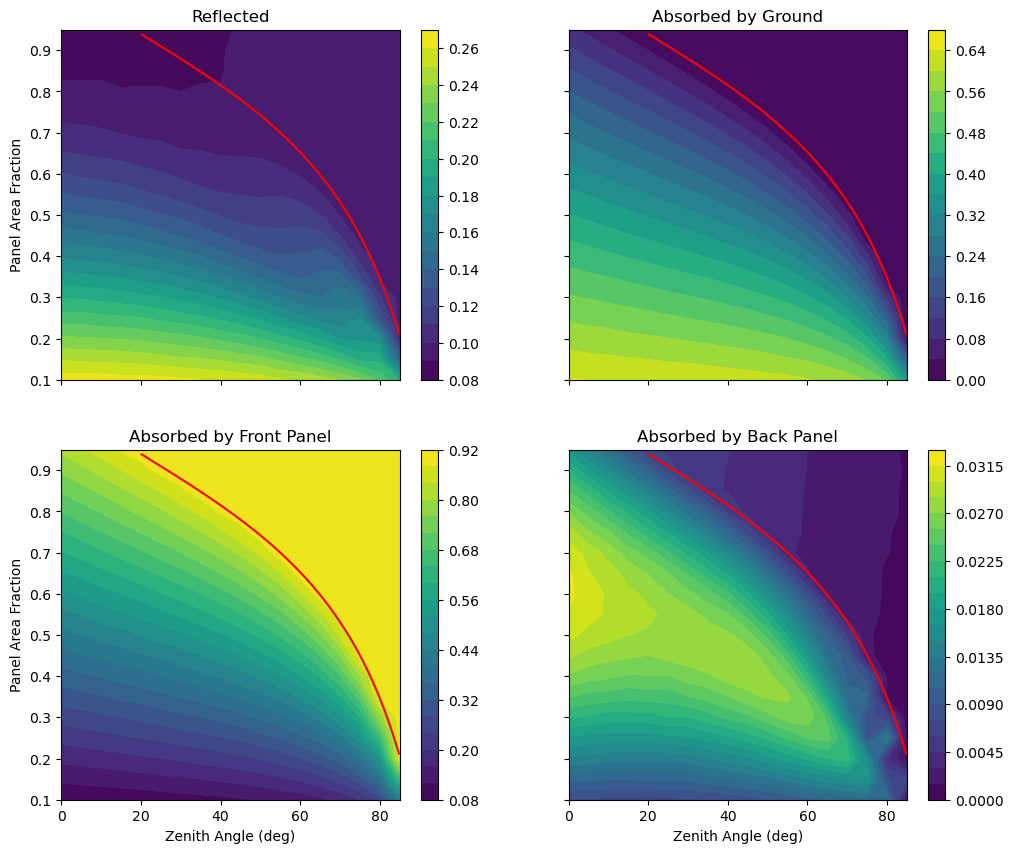

In [16]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, tbl, label in zip(
  axs.flatten(), ('refl_dir_panel_frac', 'absg_dir_panel_frac', 'absf_dir_panel_frac', 'absb_dir_panel_frac'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  p = ax.contourf(v['zenith_angle'], v['panel_frac'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Panel Area Fraction')
axs[1,0].set_ylabel('Panel Area Fraction')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

x = np.arange(0.0, 85.0, 0.1)
y = np.arange(0.10, 0.95, 0.02)
xx, yy = np.meshgrid(x, y)
z = np.cos(args['panel_tilt_rad']) + np.sin(args['panel_tilt_rad']) * np.tan(np.deg2rad(xx))
z = z * yy
for ax in axs.flatten():
  ax.contour(x, y, z, levels=[0.0, 1.0, 99.0], colors='r')

When panel is flat...

In [17]:
temp = np.zeros((len(frac), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(frac), len(zenith))), dims=['panel_frac', 'zenith_angle'],
  coords={'panel_frac': frac, 'zenith_angle': zenith}
)
tbl1 = result.copy()
tbl2 = result.copy()
tbl3 = result.copy()
tbl4 = result.copy()
with Pool() as pool:
  for i in range(len(frac)):
    for j in range(len(zenith)):
      print(f"Calculating for frac = {frac[i]:.2f}, zenith = {zenith[j]:.0f}", end="\r")
      args = defaults.copy()
      args['scene_length'] = 1.0 / frac[i]
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      args['panel_tilt_rad'] = math.radians(0.0)
      # r = doDownwardRadiation2D(**args)
      # tbl1[i,j] = r['n_upward'] / args['nphotons']
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(frac)):
  for j in range(len(zenith)):
    tbl1[i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    tbl2[i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    tbl3[i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    tbl4[i,j] = temp[i,j].get()['n_back'] / args['nphotons']

Text(0.5, 0, 'Zenith Angle (deg)')

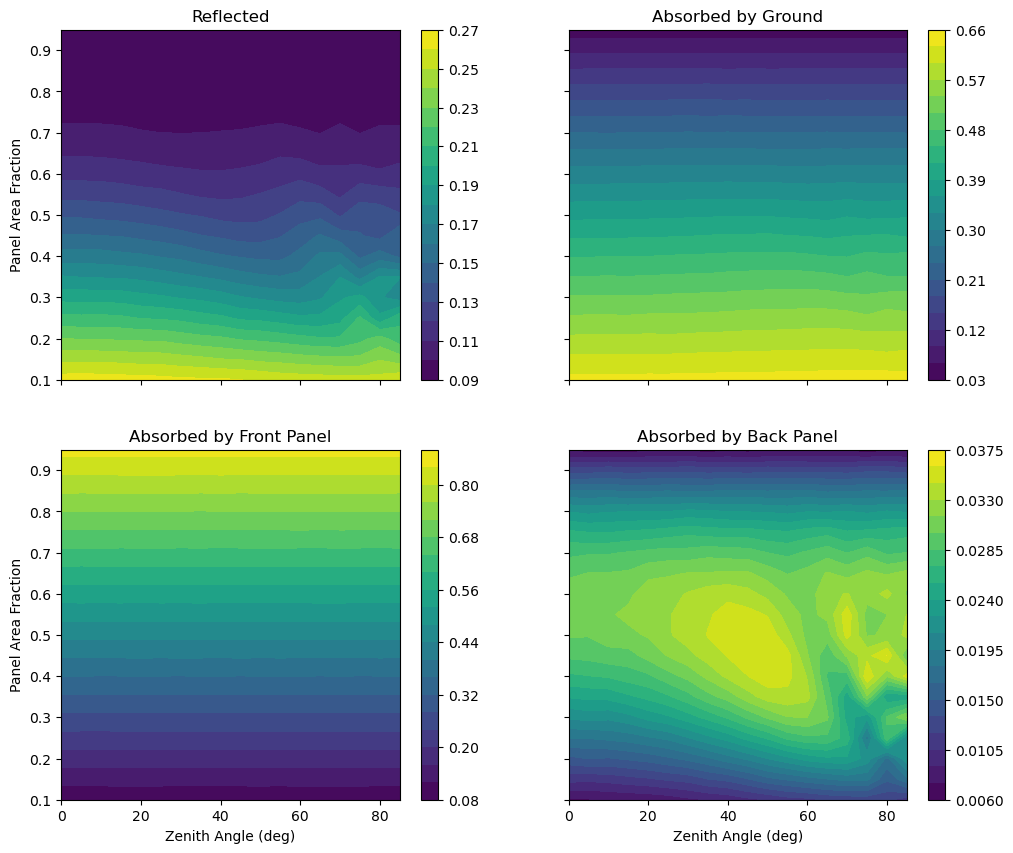

In [18]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, v, label in zip(
  axs.flatten(), (tbl1, tbl2, tbl3, tbl4),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  p = ax.contourf(v['zenith_angle'], v['panel_frac'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Panel Area Fraction')
axs[1,0].set_ylabel('Panel Area Fraction')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

Text(0.5, 0, '$\\tan(\\theta)$')

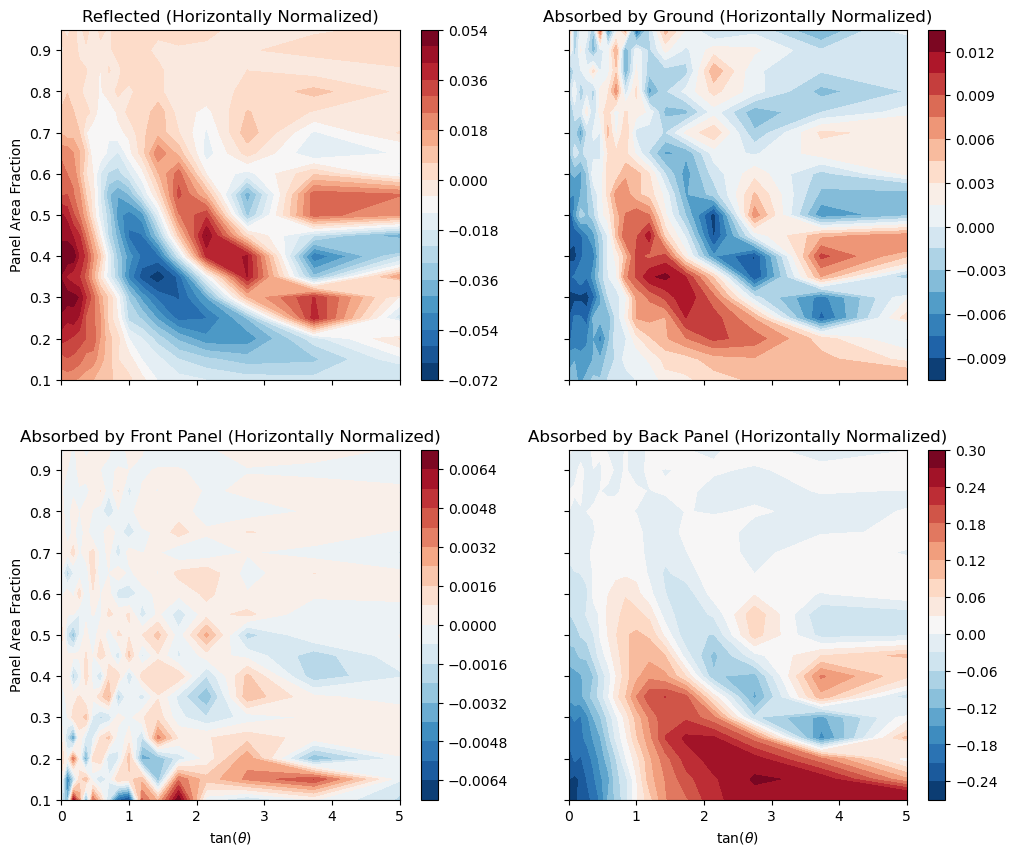

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, v, label in zip(
  axs.flatten(), (tbl1, tbl2, tbl3, tbl4),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  x = np.tan(np.deg2rad(v['zenith_angle']))
  vm = v.mean(dim='zenith_angle')
  p = ax.contourf(x, v['panel_frac'], (v-vm)/vm, levels=20, cmap='RdBu_r')
  plt.colorbar(p, ax=ax)
  ax.set_xlim(0.0, 5.0)
  ax.set_title(label + ' (Horizontally Normalized)')
axs[0,0].set_ylabel('Panel Area Fraction')
axs[1,0].set_ylabel('Panel Area Fraction')
axs[1,0].set_xlabel('$\\tan(\\theta)$')
axs[1,1].set_xlabel('$\\tan(\\theta)$')

# xticks = np.tan(np.deg2rad(np.arange(0.0, 85.0, 10.0)))
# xlabels = [f'{x:.1f}' for x in np.arange(0.0, 85.0, 10.0)]
# for ax in axs.flatten():
#   ax.set_xticks(xticks)
#   ax.set_xticklabels(xlabels)

## Panel Height

In [20]:
temp = np.zeros((len(height), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(height), len(zenith))), dims=['panel_hgt', 'zenith_angle'],
  coords={'panel_hgt': height, 'zenith_angle': zenith}
)
ds['refl_dir_panel_hgt'] = result.copy()
ds['absg_dir_panel_hgt'] = result.copy()
ds['absf_dir_panel_hgt'] = result.copy()
ds['absb_dir_panel_hgt'] = result.copy()
with Pool() as pool:
  for i in range(len(height)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['panel_height'] = height[i]
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(height)):
  for j in range(len(zenith)):
    ds['refl_dir_panel_hgt'][i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    ds['absg_dir_panel_hgt'][i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    ds['absf_dir_panel_hgt'][i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    ds['absb_dir_panel_hgt'][i,j] = temp[i,j].get()['n_back'] / args['nphotons']

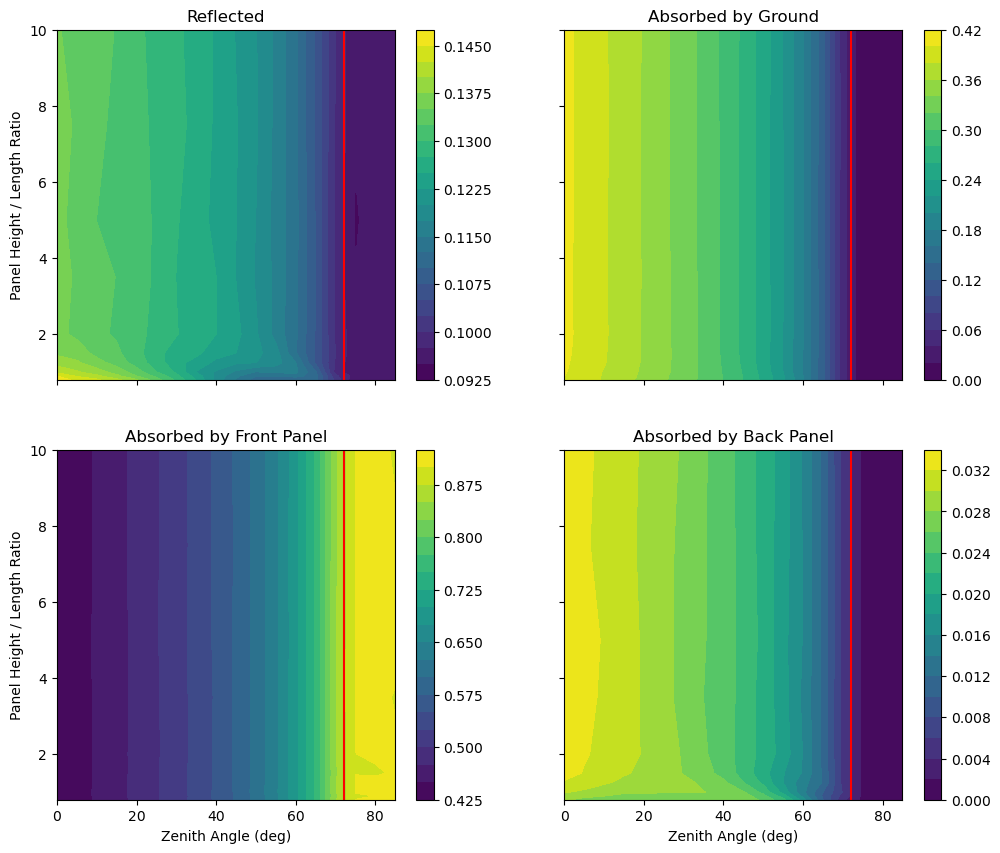

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, tbl, label in zip(
  axs.flatten(), ('refl_dir_panel_hgt', 'absg_dir_panel_hgt', 'absf_dir_panel_hgt', 'absb_dir_panel_hgt'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  p = ax.contourf(v['zenith_angle'], v['panel_hgt'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Panel Height / Length Ratio')
axs[1,0].set_ylabel('Panel Height / Length Ratio')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

angle = np.rad2deg(
    np.arctan(
        (2-np.cos(args['panel_tilt_rad'])) / np.sin(args['panel_tilt_rad'])
    )
)
for ax in axs.flatten():
  ax.axvline(x=angle, c='r')

When panel is flat...

In [22]:
temp = np.zeros((len(height), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(height), len(zenith))), dims=['panel_hgt', 'zenith_angle'],
  coords={'panel_hgt': height, 'zenith_angle': zenith}
)
tbl1 = result.copy()
tbl2 = result.copy()
tbl3 = result.copy()
tbl4 = result.copy()
with Pool() as pool:
  for i in range(len(height)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['panel_height'] = height[i]
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      args['panel_tilt_rad'] = math.radians(0.0)
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(height)):
  for j in range(len(zenith)):
    tbl1[i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    tbl2[i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    tbl3[i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    tbl4[i,j] = temp[i,j].get()['n_back'] / args['nphotons']

Text(0.5, 0, 'Zenith Angle (deg)')

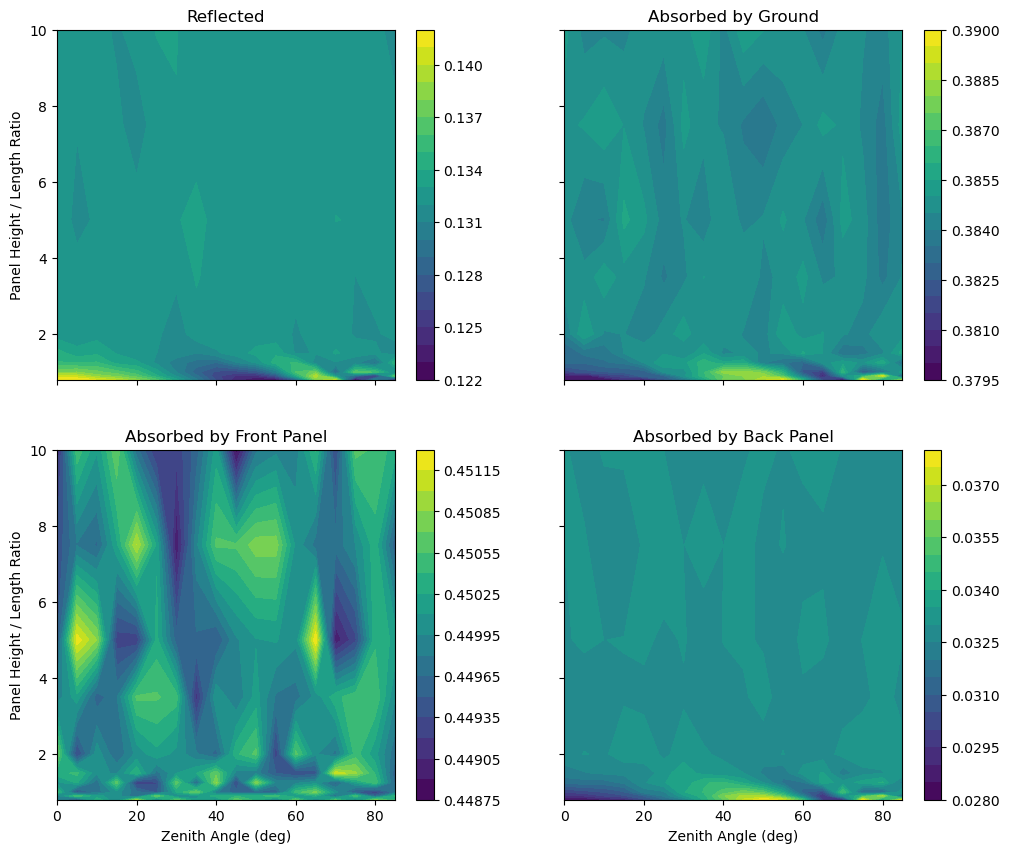

In [23]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, v, label in zip(
  axs.flatten(), (tbl1, tbl2, tbl3, tbl4),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  p = ax.contourf(v['zenith_angle'], v['panel_hgt'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Panel Height / Length Ratio')
axs[1,0].set_ylabel('Panel Height / Length Ratio')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

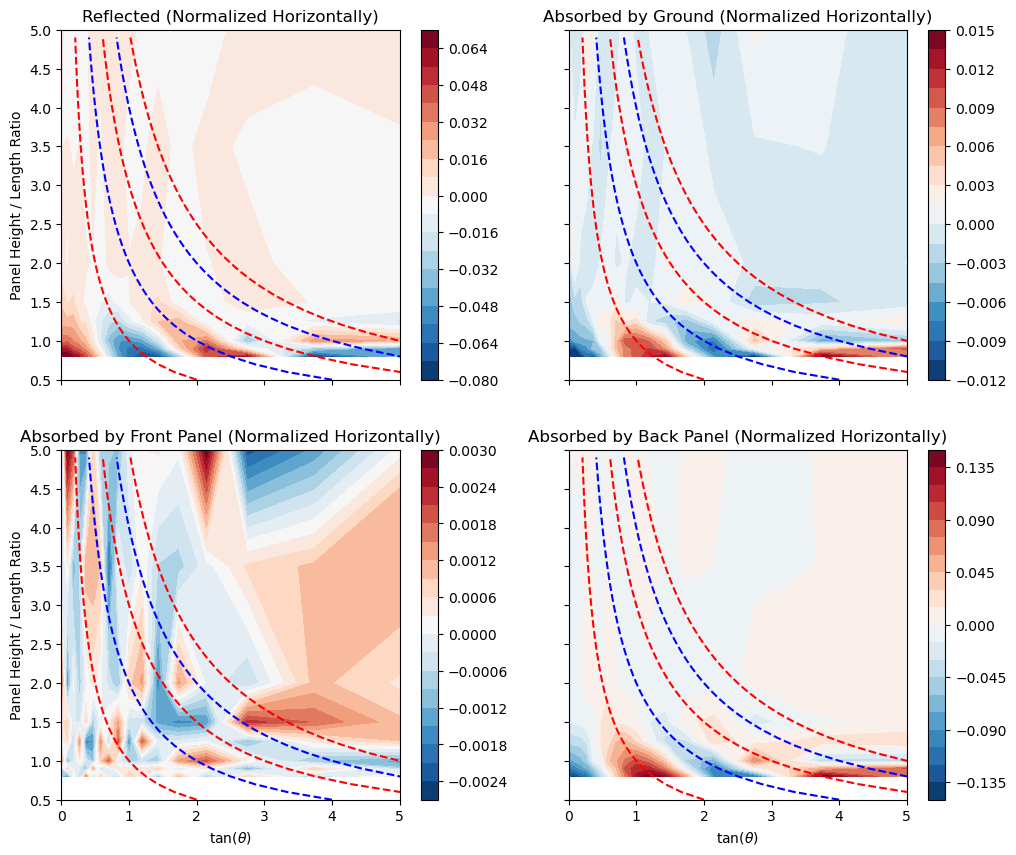

In [24]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, v, label in zip(
  axs.flatten(), (tbl1, tbl2, tbl3, tbl4),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  x = np.tan(np.deg2rad(v['zenith_angle']))
  vm = v.mean(dim='zenith_angle')
  p = ax.contourf(x, v['panel_hgt'], (v-vm)/vm, levels=20, cmap='RdBu_r')
  plt.colorbar(p, ax=ax)
  ax.set_xlim(0.0, 5.0)
  ax.set_ylim(0.5, 5.0)
  ax.set_title(label + ' (Normalized Horizontally)')
axs[0,0].set_ylabel('Panel Height / Length Ratio')
axs[1,0].set_ylabel('Panel Height / Length Ratio')
axs[1,0].set_xlabel('$\\tan(\\theta)$')
axs[1,1].set_xlabel('$\\tan(\\theta)$')

for i in range(6):
  y = np.arange(0.5, 5.0, 0.1)
  x = i / y
  for ax in axs.flatten():
    ax.plot(x, y, c='r' if i % 2 == 1 else 'b', ls='--')

Special case...

In [25]:
zenith0 = np.arctan(np.arange(0.0, 5.1, 0.1)) * 180.0 / np.pi
temp = np.zeros(len(zenith0), dtype=object)
result = xa.DataArray(
  np.zeros(len(zenith0)), dims=['zenith_angle'],
  coords={'zenith_angle': zenith0}
)
tbl1 = result.copy()
tbl2 = result.copy()
tbl3 = result.copy()
tbl4 = result.copy()
with Pool() as pool:
  for j in range(len(zenith0)):
    args = {
      'nphotons': int(1e6),
      'panel_length': 1.0,
      'panel_height': 0.8,
      'scene_length': 2.0,
      'panel_tilt_rad': math.radians(0.0),
      'albedo_front_panel': 0.1,
      'albedo_back_panel': 0.0,
      'albedo_ground': 0.5,
      'mu0': -math.cos(math.radians(zenith0[j])),
      'phi0': None,
      'output_hist': False,
    }
    temp[j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for j in range(len(zenith0)):
  tbl1[j] = temp[j].get()['n_upward'] / args['nphotons']
  tbl2[j] = temp[j].get()['n_ground'] / args['nphotons']
  tbl3[j] = temp[j].get()['n_front'] / args['nphotons']
  tbl4[j] = temp[j].get()['n_back'] / args['nphotons']

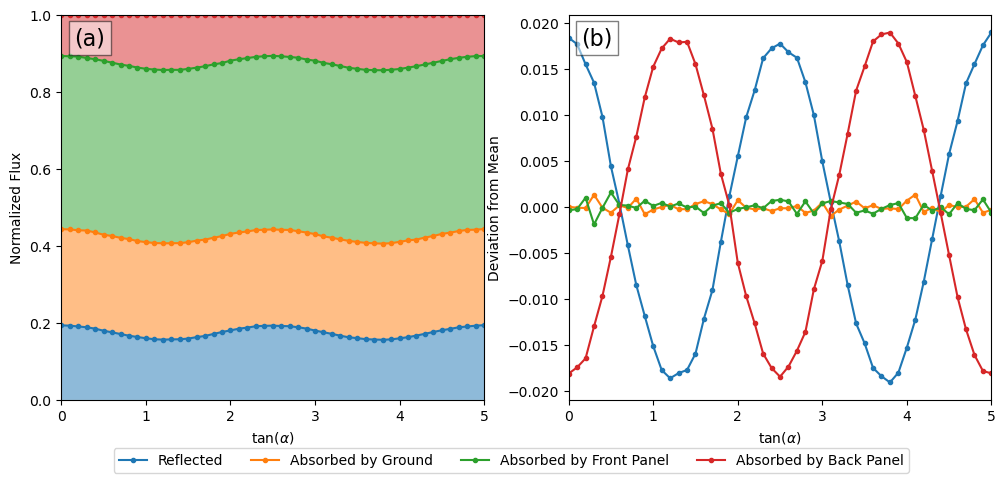

In [26]:
fig, axs = plt.subplots(1,2,figsize=(12,5), sharex=True)
yacc = np.zeros(len(zenith0))
for v, label in zip(
  (tbl1, tbl2, tbl3, tbl4),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  x = np.tan(np.deg2rad(v['zenith_angle']))
  y = v
  axs[0].plot(x, y+yacc, '.-', label=label)
  axs[0].fill_between(x, yacc, yacc+y, alpha=0.5)
  axs[1].plot(x, y-y.mean(), '.-', label=label)
  yacc += y

axs[0].set_xlim(0.0, 5.0)
axs[0].set_ylim(0.0, 1.0)
axs[0].set_xlabel('$\\tan(\\alpha)$')
axs[0].set_ylabel('Normalized Flux')
axs[1].set_xlabel('$\\tan(\\alpha)$')
axs[1].set_ylabel('Deviation from Mean')

axs[0].text(0.03, 0.97, '(a)', transform=axs[0].transAxes, ha='left', va='top', size=16,
            bbox=dict(facecolor='white', alpha=0.5))
axs[1].text(0.03, 0.97, '(b)', transform=axs[1].transAxes, ha='left', va='top', size=16,
            bbox=dict(facecolor='white', alpha=0.5))

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=4, bbox_to_anchor=(0.0, -0.05, 1.0, 0.1))

## Panel Tilt Angle

In [27]:
temp = np.zeros((len(panel_tilt_deg), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(panel_tilt_deg), len(zenith))), dims=['panel_angle', 'zenith_angle'],
  coords={'panel_angle': panel_tilt_deg, 'zenith_angle': zenith}
)
ds['refl_dir_panel_angle'] = result.copy()
ds['absg_dir_panel_angle'] = result.copy()
ds['absf_dir_panel_angle'] = result.copy()
ds['absb_dir_panel_angle'] = result.copy()
with Pool() as pool:
  for i in range(len(panel_tilt_deg)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['panel_tilt_rad'] = math.radians(panel_tilt_deg[i])
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(panel_tilt_deg)):
  for j in range(len(zenith)):
    ds['refl_dir_panel_angle'][i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    ds['absg_dir_panel_angle'][i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    ds['absf_dir_panel_angle'][i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    ds['absb_dir_panel_angle'][i,j] = temp[i,j].get()['n_back'] / args['nphotons']

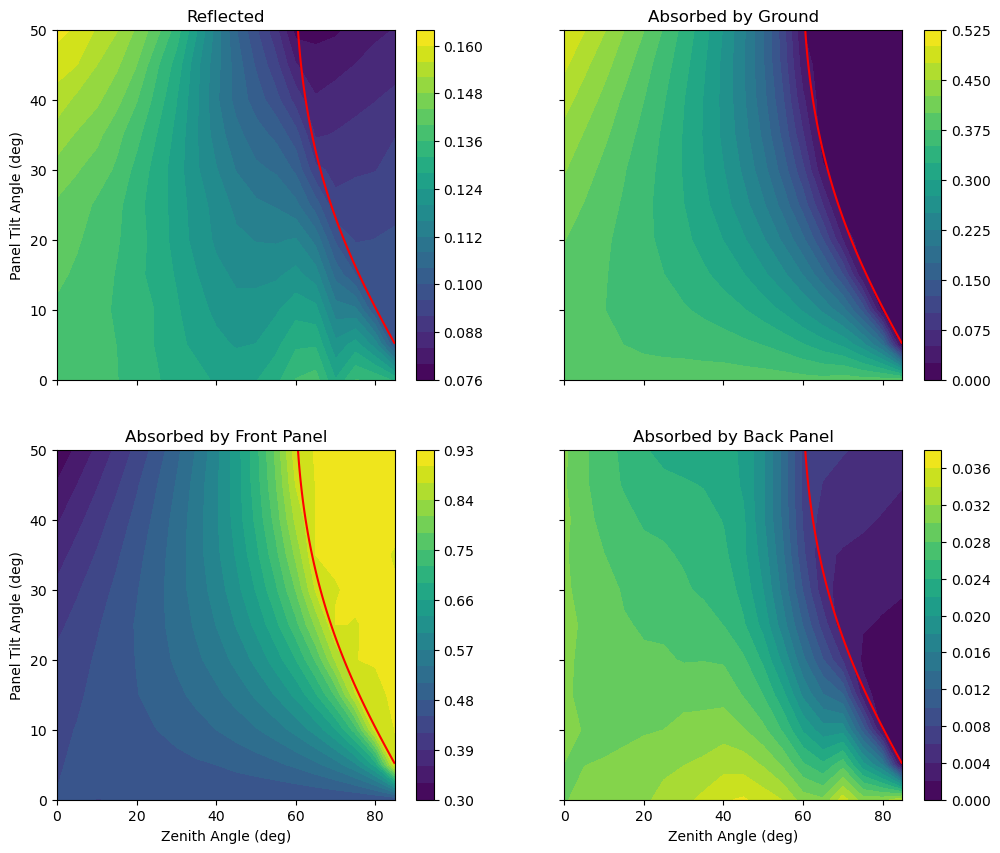

In [28]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, tbl, label in zip(
  axs.flatten(), ('refl_dir_panel_angle', 'absg_dir_panel_angle', 'absf_dir_panel_angle', 'absb_dir_panel_angle'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  p = ax.contourf(v['zenith_angle'], v['panel_angle'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Panel Tilt Angle (deg)')
axs[1,0].set_ylabel('Panel Tilt Angle (deg)')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

x = np.arange(0.0, 85.0, 0.1)
y = np.arange(0.0, 50.0, 0.1)
xx, yy = np.meshgrid(x, y)
z = np.cos(np.deg2rad(yy)) + np.sin(np.deg2rad(yy)) * np.tan(np.deg2rad(xx))
for ax in axs.flatten():
    ax.contour(x, y, z, levels=[0.0, 2.0, 99.0], colors='r')

When backpanel albedo is purely reflective...

In [29]:
temp = np.zeros((len(panel_tilt_deg), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(panel_tilt_deg), len(zenith))), dims=['panel_angle', 'zenith_angle'],
  coords={'panel_angle': panel_tilt_deg, 'zenith_angle': zenith}
)
tbl1 = result.copy()
tbl2 = result.copy()
tbl3 = result.copy()
tbl4 = result.copy()
with Pool() as pool:
  for i in range(len(panel_tilt_deg)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['panel_tilt_rad'] = math.radians(panel_tilt_deg[i])
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      args['albedo_back_panel'] = 1.0
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(panel_tilt_deg)):
  for j in range(len(zenith)):
    tbl1[i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    tbl2[i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    tbl3[i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    tbl4[i,j] = temp[i,j].get()['n_back'] / args['nphotons']

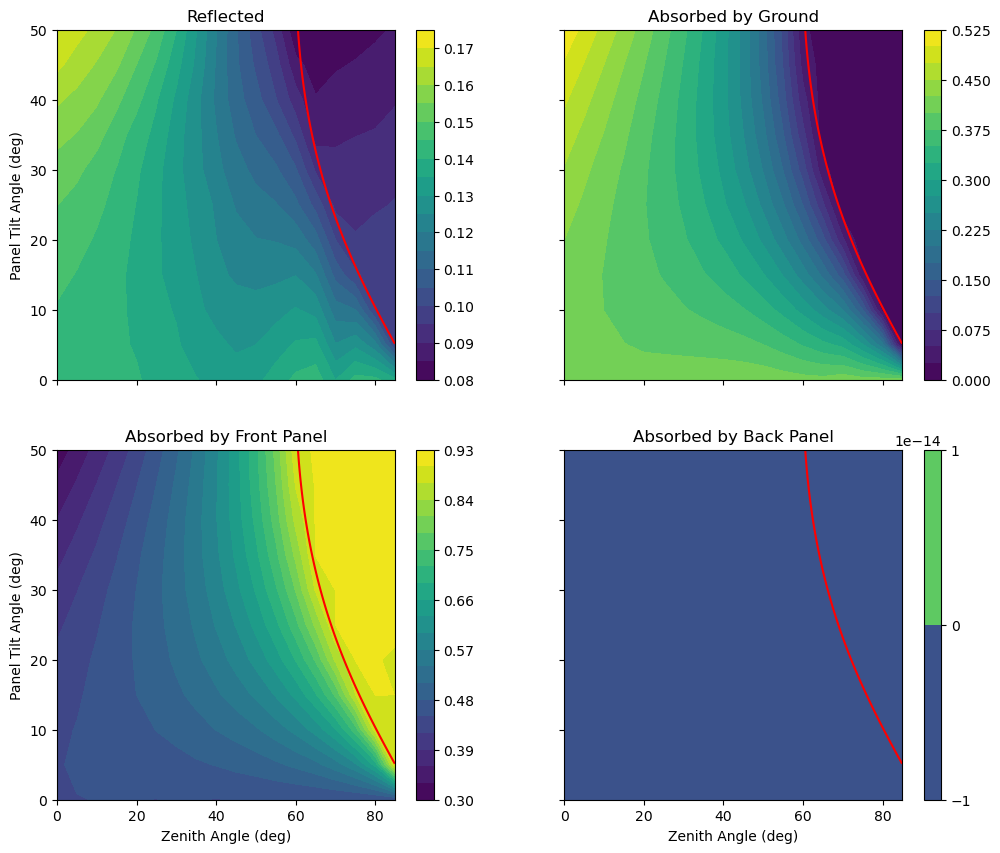

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, v, label in zip(
  axs.flatten(), (tbl1, tbl2, tbl3, tbl4),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  p = ax.contourf(v['zenith_angle'], v['panel_angle'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Panel Tilt Angle (deg)')
axs[1,0].set_ylabel('Panel Tilt Angle (deg)')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

x = np.arange(0.0, 85.0, 0.1)
y = np.arange(0.0, 50.0, 0.1)
xx, yy = np.meshgrid(x, y)
z = np.cos(np.deg2rad(yy)) + np.sin(np.deg2rad(yy)) * np.tan(np.deg2rad(xx))
for ax in axs.flatten():
    ax.contour(x, y, z, levels=[0.0, 2.0, 99.0], colors='r')

When backpanel albedo is purely absorptive...

In [31]:
temp = np.zeros((len(panel_tilt_deg), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(panel_tilt_deg), len(zenith))), dims=['panel_angle', 'zenith_angle'],
  coords={'panel_angle': panel_tilt_deg, 'zenith_angle': zenith}
)
tbl1 = result.copy()
tbl2 = result.copy()
tbl3 = result.copy()
tbl4 = result.copy()
with Pool() as pool:
  for i in range(len(panel_tilt_deg)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['panel_tilt_rad'] = math.radians(panel_tilt_deg[i])
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      args['albedo_back_panel'] = 0.0
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(panel_tilt_deg)):
  for j in range(len(zenith)):
    tbl1[i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    tbl2[i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    tbl3[i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    tbl4[i,j] = temp[i,j].get()['n_back'] / args['nphotons']

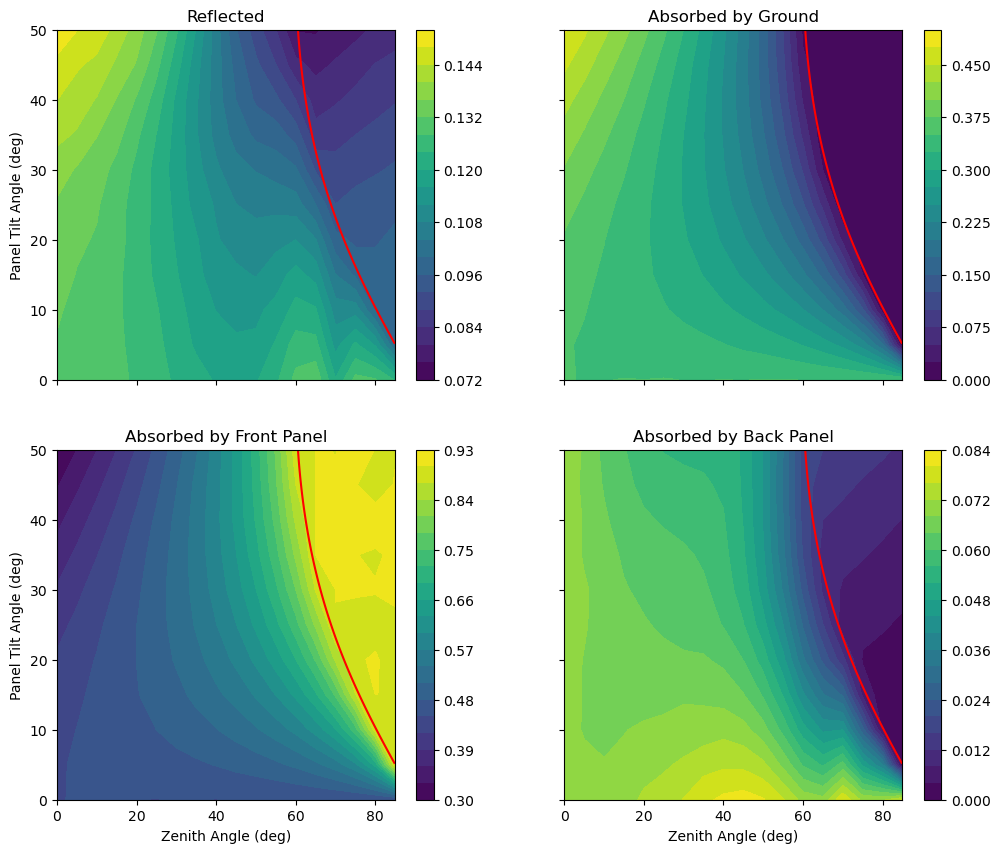

In [32]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, v, label in zip(
  axs.flatten(), (tbl1, tbl2, tbl3, tbl4),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  p = ax.contourf(v['zenith_angle'], v['panel_angle'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Panel Tilt Angle (deg)')
axs[1,0].set_ylabel('Panel Tilt Angle (deg)')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

x = np.arange(0.0, 85.0, 0.1)
y = np.arange(0.0, 50.0, 0.1)
xx, yy = np.meshgrid(x, y)
z = np.cos(np.deg2rad(yy)) + np.sin(np.deg2rad(yy)) * np.tan(np.deg2rad(xx))
for ax in axs.flatten():
    ax.contour(x, y, z, levels=[0.0, 2.0, 99.0], colors='r')

## Front Panel Albedo

In [33]:
temp = np.zeros((len(albf), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(albf), len(zenith))), dims=['albf', 'zenith_angle'],
  coords={'albf': albf, 'zenith_angle': zenith}
)
ds['refl_dir_albf'] = result.copy()
ds['absg_dir_albf'] = result.copy()
ds['absf_dir_albf'] = result.copy()
ds['absb_dir_albf'] = result.copy()
with Pool() as pool:
  for i in range(len(albf)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['albedo_front_panel'] = albf[i]
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(albf)):
  for j in range(len(zenith)):
    ds['refl_dir_albf'][i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    ds['absg_dir_albf'][i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    ds['absf_dir_albf'][i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    ds['absb_dir_albf'][i,j] = temp[i,j].get()['n_back'] / args['nphotons']

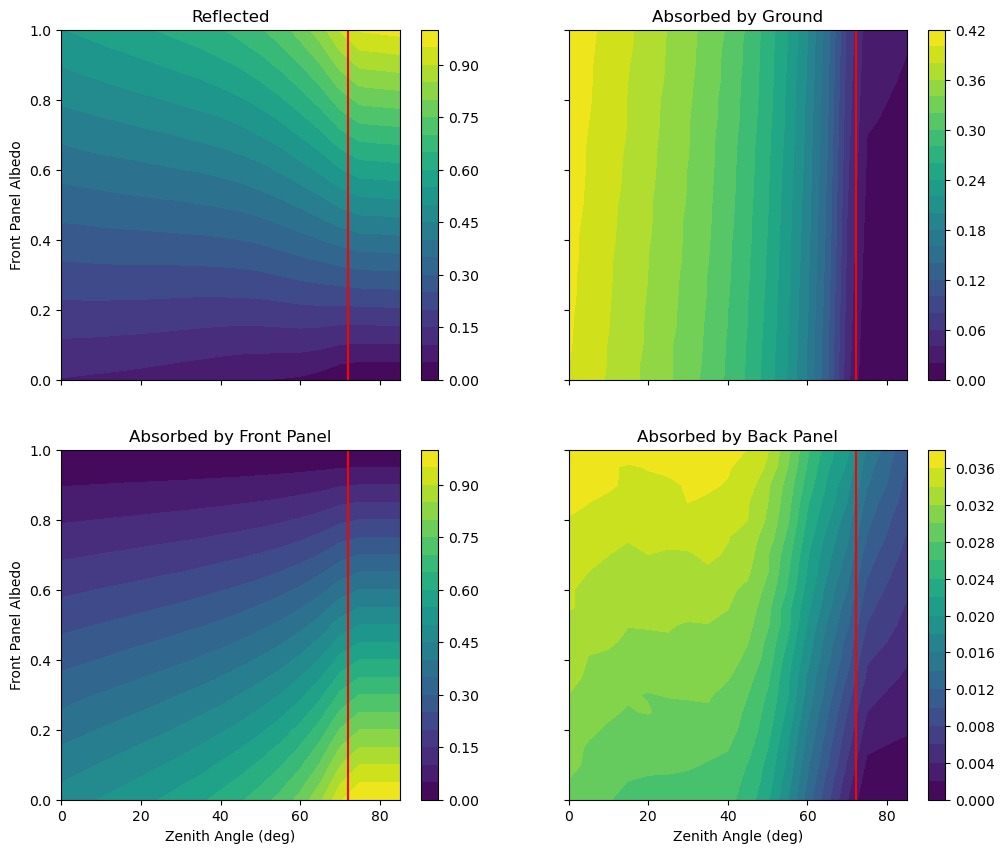

In [34]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, tbl, label in zip(
  axs.flatten(), ('refl_dir_albf', 'absg_dir_albf', 'absf_dir_albf', 'absb_dir_albf'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  p = ax.contourf(v['zenith_angle'], v['albf'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Front Panel Albedo')
axs[1,0].set_ylabel('Front Panel Albedo')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

angle = np.rad2deg(
    np.arctan(
        (2-np.cos(args['panel_tilt_rad'])) / np.sin(args['panel_tilt_rad'])
    )
)
for ax in axs.flatten():
  ax.axvline(x=angle, c='r')

## Back Panel Albedo

In [35]:
temp = np.zeros((len(albb), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(albb), len(zenith))), dims=['albb', 'zenith_angle'],
  coords={'albb': albb, 'zenith_angle': zenith}
)
ds['refl_dir_albb'] = result.copy()
ds['absg_dir_albb'] = result.copy()
ds['absf_dir_albb'] = result.copy()
ds['absb_dir_albb'] = result.copy()
with Pool() as pool:
  for i in range(len(albb)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['albedo_back_panel'] = albb[i]
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      temp[i,j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(albb)):
  for j in range(len(zenith)):
    ds['refl_dir_albb'][i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    ds['absg_dir_albb'][i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    ds['absf_dir_albb'][i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    ds['absb_dir_albb'][i,j] = temp[i,j].get()['n_back'] / args['nphotons']

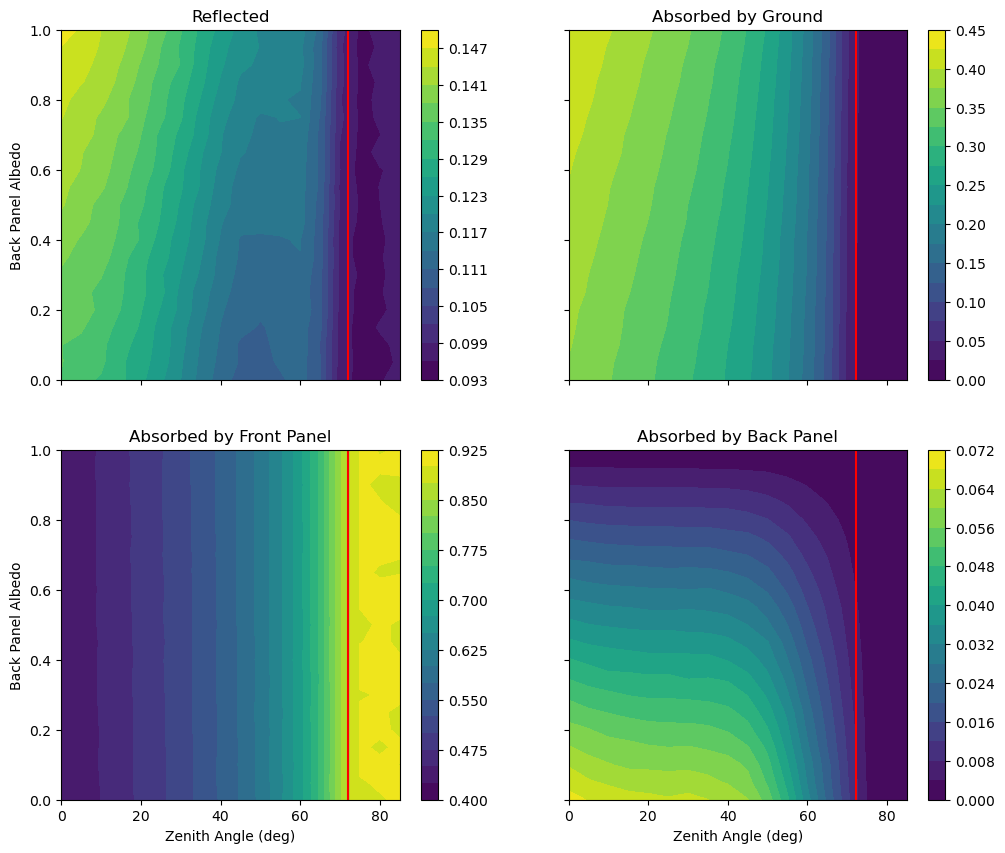

In [36]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, tbl, label in zip(
  axs.flatten(), ('refl_dir_albb', 'absg_dir_albb', 'absf_dir_albb', 'absb_dir_albb'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  p = ax.contourf(v['zenith_angle'], v['albb'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Back Panel Albedo')
axs[1,0].set_ylabel('Back Panel Albedo')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

angle = np.rad2deg(
    np.arctan(
        (2-np.cos(args['panel_tilt_rad'])) / np.sin(args['panel_tilt_rad'])
    )
)
for ax in axs.flatten():
  ax.axvline(x=angle, c='r')

## Ground Albedo

In [37]:
temp = np.zeros((len(albg), len(zenith)), dtype=object)
result = xa.DataArray(
  np.zeros((len(albg), len(zenith))), dims=['albg', 'zenith_angle'],
  coords={'albg': albg, 'zenith_angle': zenith}
)
ds['refl_dir_albg'] = result.copy()
ds['absg_dir_albg'] = result.copy()
ds['absf_dir_albg'] = result.copy()
ds['absb_dir_albg'] = result.copy()
with Pool() as pool:
  for i in range(len(albg)):
    for j in range(len(zenith)):
      args = defaults.copy()
      args['albedo_ground'] = albg[i]
      args['mu0'] = -math.cos(math.radians(zenith[j]))
      temp[i, j] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(albg)):
  for j in range(len(zenith)):
    ds['refl_dir_albg'][i,j] = temp[i,j].get()['n_upward'] / args['nphotons']
    ds['absg_dir_albg'][i,j] = temp[i,j].get()['n_ground'] / args['nphotons']
    ds['absf_dir_albg'][i,j] = temp[i,j].get()['n_front'] / args['nphotons']
    ds['absb_dir_albg'][i,j] = temp[i,j].get()['n_back'] / args['nphotons']

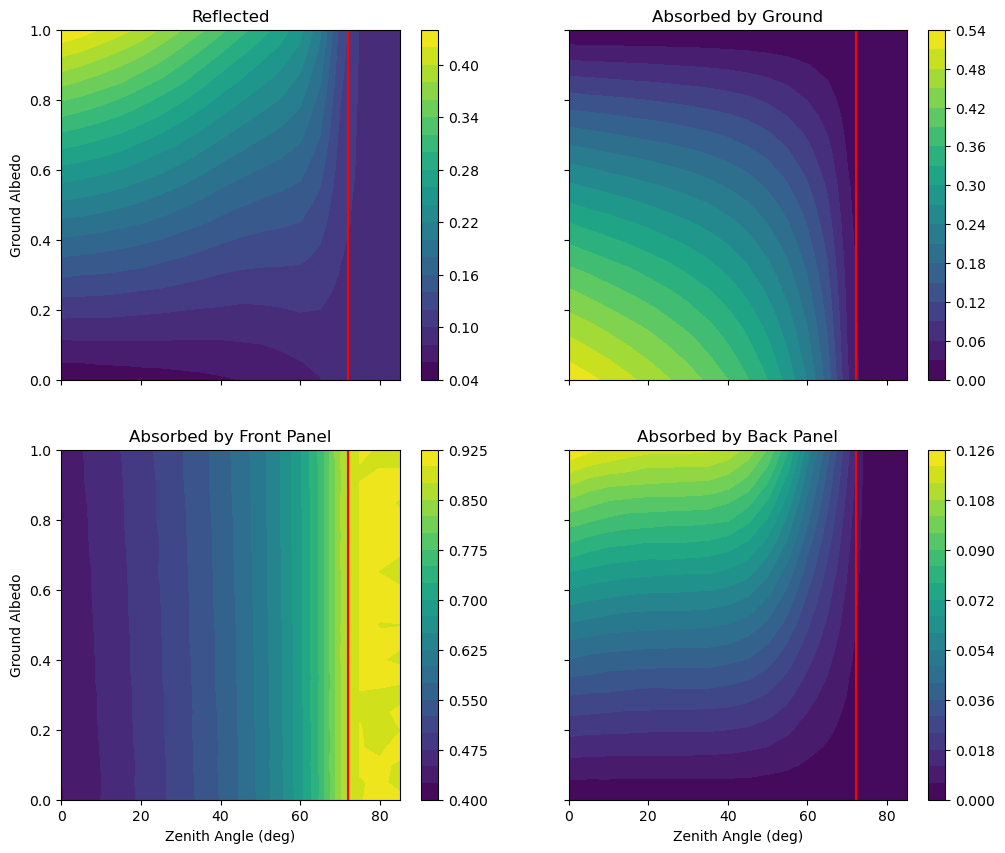

In [38]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), sharex=True, sharey=True)
for ax, tbl, label in zip(
  axs.flatten(), ('refl_dir_albg', 'absg_dir_albg', 'absf_dir_albg', 'absb_dir_albg'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  p = ax.contourf(v['zenith_angle'], v['albg'], v, levels=20)
  plt.colorbar(p, ax=ax)
  ax.set_title(label)
axs[0,0].set_ylabel('Ground Albedo')
axs[1,0].set_ylabel('Ground Albedo')
axs[1,0].set_xlabel('Zenith Angle (deg)')
axs[1,1].set_xlabel('Zenith Angle (deg)')

angle = np.rad2deg(
    np.arctan(
        (2-np.cos(args['panel_tilt_rad'])) / np.sin(args['panel_tilt_rad'])
    )
)
for ax in axs.flatten():
  ax.axvline(x=angle, c='r')

# Relationship between Reflected Diffuse Solar Radiation and Parameters

In [39]:
defaults = {
  'nphotons': int(1e7),
  'panel_length': 1.0,
  'panel_height': 1.0,
  'scene_length': 2.0,
  'panel_tilt_rad': math.radians(20.0),
  'albedo_front_panel': 0.1,
  'albedo_back_panel': 0.6,
  'albedo_ground': 0.3,
  'mu0': None,
  'phi0': None,
  'output_hist': False,
}

## Panel Area Fraction

In [40]:
temp = np.zeros(len(frac), dtype=object)
result = xa.DataArray(
  np.zeros(len(frac)), dims=['panel_frac'], coords={'panel_frac': frac}
)
ds['refl_dif_panel_frac'] = result.copy()
ds['absg_dif_panel_frac'] = result.copy()
ds['absf_dif_panel_frac'] = result.copy()
ds['absb_dif_panel_frac'] = result.copy()
with Pool() as pool:
  for i in range(len(frac)):
    args = defaults.copy()
    args['scene_length'] = 1.0 / frac[i]
    temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(frac)):
  ds['refl_dif_panel_frac'][i] = temp[i].get()['n_upward'] / args['nphotons']
  ds['absg_dif_panel_frac'][i] = temp[i].get()['n_ground'] / args['nphotons']
  ds['absf_dif_panel_frac'][i] = temp[i].get()['n_front'] / args['nphotons']
  ds['absb_dif_panel_frac'][i] = temp[i].get()['n_back'] / args['nphotons']

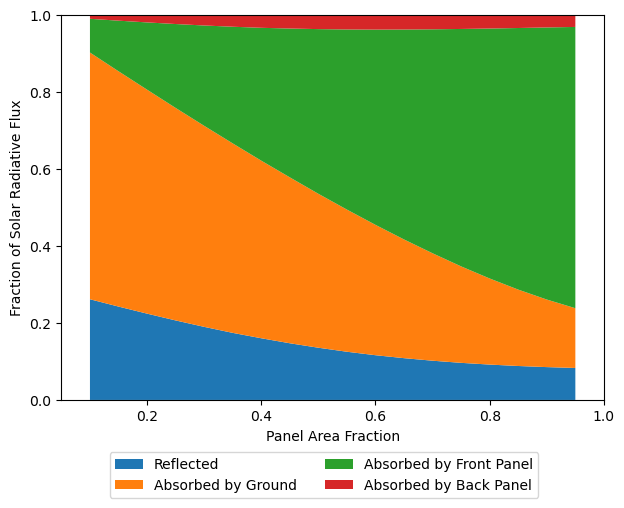

In [41]:
fig, ax = plt.subplots(figsize=(7,5))
yacc = None
for tbl, label in zip(
  ('refl_dif_panel_frac', 'absg_dif_panel_frac', 'absf_dif_panel_frac', 'absb_dif_panel_frac'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  if yacc is None:
    yacc = np.zeros(len(v))
  ax.fill_between(v['panel_frac'], yacc, yacc+v, label=label)
  yacc += v
ax.set_xlim(0.05, 1.00)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Panel Area Fraction')
ax.set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.10, 1.0, 0.05))

## Panel Height

In [42]:
temp = np.zeros(len(height), dtype=object)
result = xa.DataArray(
  np.zeros(len(height)), dims=['panel_hgt'], coords={'panel_hgt': height}
)
ds['refl_dif_panel_hgt'] = result.copy()
ds['absg_dif_panel_hgt'] = result.copy()
ds['absf_dif_panel_hgt'] = result.copy()
ds['absb_dif_panel_hgt'] = result.copy()
with Pool() as pool:
  for i in range(len(height)):
    args = defaults.copy()
    args['panel_height'] = height[i]
    temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(height)):
  ds['refl_dif_panel_hgt'][i] = temp[i].get()['n_upward'] / args['nphotons']
  ds['absg_dif_panel_hgt'][i] = temp[i].get()['n_ground'] / args['nphotons']
  ds['absf_dif_panel_hgt'][i] = temp[i].get()['n_front'] / args['nphotons']
  ds['absb_dif_panel_hgt'][i] = temp[i].get()['n_back'] / args['nphotons']

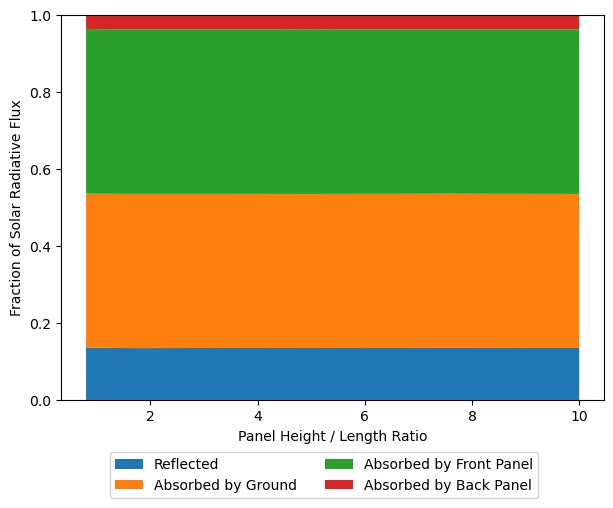

In [43]:
fig, ax = plt.subplots(figsize=(7,5))
yacc = None
for tbl, label in zip(
  ('refl_dif_panel_hgt', 'absg_dif_panel_hgt', 'absf_dif_panel_hgt', 'absb_dif_panel_hgt'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  if yacc is None:
    yacc = np.zeros(len(v))
  ax.fill_between(v['panel_hgt'], yacc, yacc+v, label=label)
  yacc += v
# ax.set_xlim(0.05, 1.00)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Panel Height / Length Ratio')
ax.set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.10, 1.0, 0.05))

## Panel Tilt Angle

In [44]:
temp = np.zeros(len(panel_tilt_deg), dtype=object)
result = xa.DataArray(
  np.zeros(len(panel_tilt_deg)), dims=['panel_angle'], coords={'panel_angle': panel_tilt_deg}
)
ds['refl_dif_panel_angle'] = result.copy()
ds['absg_dif_panel_angle'] = result.copy()
ds['absf_dif_panel_angle'] = result.copy()
ds['absb_dif_panel_angle'] = result.copy()
with Pool() as pool:
  for i in range(len(panel_tilt_deg)):
    args = defaults.copy()
    args['panel_tilt_rad'] = math.radians(panel_tilt_deg[i])
    temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(panel_tilt_deg)):
  ds['refl_dif_panel_angle'][i] = temp[i].get()['n_upward'] / args['nphotons']
  ds['absg_dif_panel_angle'][i] = temp[i].get()['n_ground'] / args['nphotons']
  ds['absf_dif_panel_angle'][i] = temp[i].get()['n_front'] / args['nphotons']
  ds['absb_dif_panel_angle'][i] = temp[i].get()['n_back'] / args['nphotons']

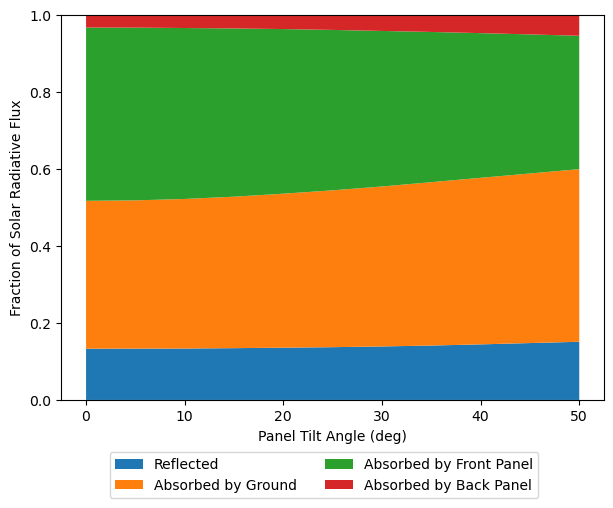

In [45]:
fig, ax = plt.subplots(figsize=(7,5))
yacc = None
for tbl, label in zip(
  ('refl_dif_panel_angle', 'absg_dif_panel_angle', 'absf_dif_panel_angle', 'absb_dif_panel_angle'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  if yacc is None:
    yacc = np.zeros(len(v))
  ax.fill_between(v['panel_angle'], yacc, yacc+v, label=label)
  yacc += v
# ax.set_xlim(0.05, 1.00)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Panel Tilt Angle (deg)')
ax.set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.10, 1.0, 0.05))

## Front Panel Albedo

In [46]:
temp = np.zeros(len(albf), dtype=object)
result = xa.DataArray(
  np.zeros(len(albf)), dims=['albf'], coords={'albf': albf}
)
ds['refl_dif_albf'] = result.copy()
ds['absg_dif_albf'] = result.copy()
ds['absf_dif_albf'] = result.copy()
ds['absb_dif_albf'] = result.copy()
with Pool() as pool:
  for i in range(len(albf)):
    args = defaults.copy()
    args['albedo_front_panel'] = albf[i]
    temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(albf)):
  ds['refl_dif_albf'][i] = temp[i].get()['n_upward'] / args['nphotons']
  ds['absg_dif_albf'][i] = temp[i].get()['n_ground'] / args['nphotons']
  ds['absf_dif_albf'][i] = temp[i].get()['n_front'] / args['nphotons']
  ds['absb_dif_albf'][i] = temp[i].get()['n_back'] / args['nphotons']

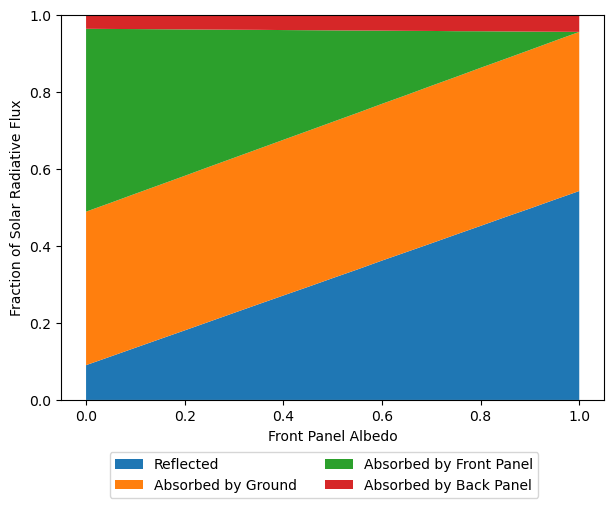

In [47]:
fig, ax = plt.subplots(figsize=(7,5))
yacc = None
for tbl, label in zip(
  ('refl_dif_albf', 'absg_dif_albf', 'absf_dif_albf', 'absb_dif_albf'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  if yacc is None:
    yacc = np.zeros(len(v))
  ax.fill_between(v['albf'], yacc, yacc+v, label=label)
  yacc += v
# ax.set_xlim(0.05, 1.00)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Front Panel Albedo')
ax.set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.10, 1.0, 0.05))

## Back Panel Albedo

In [48]:
temp = np.zeros(len(albb), dtype=object)
result = xa.DataArray(
  np.zeros(len(albb)), dims=['albb'], coords={'albb': albb}
)
ds['refl_dif_albb'] = result.copy()
ds['absg_dif_albb'] = result.copy()
ds['absf_dif_albb'] = result.copy()
ds['absb_dif_albb'] = result.copy()
with Pool() as pool:
  for i in range(len(albb)):
    args = defaults.copy()
    args['albedo_back_panel'] = albb[i]
    temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(albb)):
  ds['refl_dif_albb'][i] = temp[i].get()['n_upward'] / args['nphotons']
  ds['absg_dif_albb'][i] = temp[i].get()['n_ground'] / args['nphotons']
  ds['absf_dif_albb'][i] = temp[i].get()['n_front'] / args['nphotons']
  ds['absb_dif_albb'][i] = temp[i].get()['n_back'] / args['nphotons']

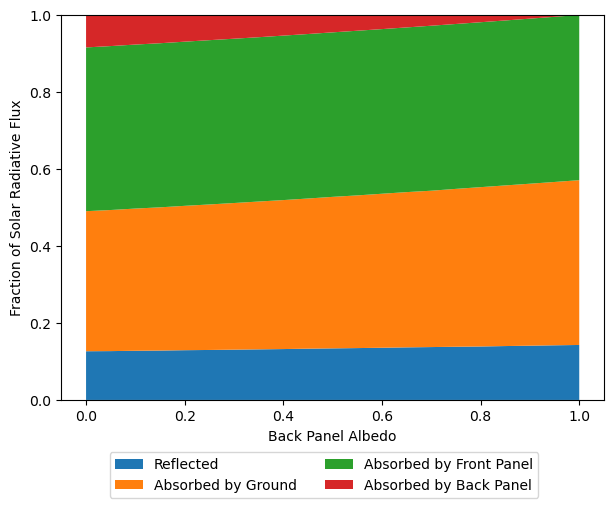

In [49]:
fig, ax = plt.subplots(figsize=(7,5))
yacc = None
for tbl, label in zip(
  ('refl_dif_albb', 'absg_dif_albb', 'absf_dif_albb', 'absb_dif_albb'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  if yacc is None:
    yacc = np.zeros(len(v))
  ax.fill_between(v['albb'], yacc, yacc+v, label=label)
  yacc += v
# ax.set_xlim(0.05, 1.00)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Back Panel Albedo')
ax.set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.10, 1.0, 0.05))

## Ground Albedo

In [50]:
temp = np.zeros(len(albg), dtype=object)
result = xa.DataArray(
  np.zeros(len(albg)), dims=['albg'], coords={'albg': albg}
)
ds['refl_dif_albg'] = result.copy()
ds['absg_dif_albg'] = result.copy()
ds['absf_dif_albg'] = result.copy()
ds['absb_dif_albg'] = result.copy()
with Pool() as pool:
  for i in range(len(albg)):
    args = defaults.copy()
    args['albedo_ground'] = albg[i]
    temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  pool.join()

for i in range(len(albg)):
  ds['refl_dif_albg'][i] = temp[i].get()['n_upward'] / args['nphotons']
  ds['absg_dif_albg'][i] = temp[i].get()['n_ground'] / args['nphotons']
  ds['absf_dif_albg'][i] = temp[i].get()['n_front'] / args['nphotons']
  ds['absb_dif_albg'][i] = temp[i].get()['n_back'] / args['nphotons']

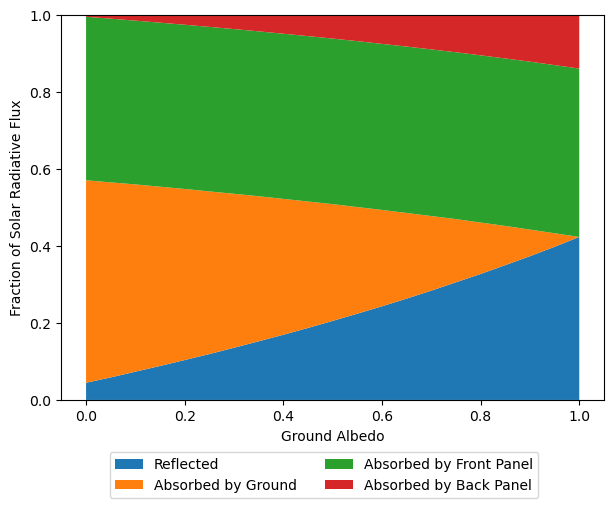

In [51]:
fig, ax = plt.subplots(figsize=(7,5))
yacc = None
for tbl, label in zip(
  ('refl_dif_albg', 'absg_dif_albg', 'absf_dif_albg', 'absb_dif_albg'),
  ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
):
  v = ds[tbl]
  if yacc is None:
    yacc = np.zeros(len(v))
  ax.fill_between(v['albg'], yacc, yacc+v, label=label)
  yacc += v
# ax.set_xlim(0.05, 1.00)
ax.set_ylim(0.0, 1.0)
ax.set_xlabel('Ground Albedo')
ax.set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.10, 1.0, 0.05))

# Save Data

In [52]:
ds

<xarray.Dataset>
Dimensions:               (panel_frac: 18, zenith_angle: 18, panel_hgt: 10,
                           panel_angle: 11, albf: 21, albb: 21, albg: 21)
Coordinates:
  * panel_frac            (panel_frac) float64 0.1 0.15 0.2 ... 0.85 0.9 0.95
  * zenith_angle          (zenith_angle) float64 0.0 5.0 10.0 ... 75.0 80.0 85.0
  * panel_hgt             (panel_hgt) float64 0.8 0.9 1.0 1.25 ... 5.0 7.5 10.0
  * panel_angle           (panel_angle) float64 0.0 5.0 10.0 ... 40.0 45.0 50.0
  * albf                  (albf) float64 0.0 0.05 0.1 0.15 ... 0.85 0.9 0.95 1.0
  * albb                  (albb) float64 0.0 0.05 0.1 0.15 ... 0.85 0.9 0.95 1.0
  * albg                  (albg) float64 0.0 0.05 0.1 0.15 ... 0.85 0.9 0.95 1.0
Data variables: (12/48)
    refl_dir_panel_frac   (panel_frac, zenith_angle) float64 0.2651 ... 0.097
    absg_dir_panel_frac   (panel_frac, zenith_angle) float64 0.642 ... 0.001773
    absf_dir_panel_frac   (panel_frac, zenith_angle) float64 0.08559 ... 0.8998
    absb_dir_panel_frac   (panel_frac, zenith_angle) float64 0.007258 ... 0.0...
    refl_dir_panel_hgt    (panel_hgt, zenith_angle) float64 0.1462 ... 0.09705
    absg_dir_panel_hgt    (panel_hgt, zenith_angle) float64 0.3998 ... 0.002132
    ...                    ...
    absf_dif_albb         (albb) float64 0.4254 0.4258 0.426 ... 0.429 0.4292
    absb_dif_albb         (albb) float64 0.08436 0.08085 ... 0.004835 0.0
    refl_dif_albg         (albg) float64 0.04468 0.05858 ... 0.3978 0.4233
    absg_dif_albg         (albg) float64 0.5259 0.5065 0.4864 ... 0.03521 0.0
    absf_dif_albg         (albg) float64 0.4247 0.4252 0.4254 ... 0.4367 0.4374
    absb_dif_albg         (albg) float64 0.004709 0.009703 ... 0.1303 0.1393

In [53]:
ds.to_netcdf(DATA_PATH)

# Interactive Visualization

## Direct Shortwave

In [14]:
def g1(frac, panel_height, panel_tilt_deg, albf, albb, albg):
  zenith = np.arange(0.0, 85.1, 1.0)
  temp = np.zeros(len(zenith), dtype=object)
  refl = np.zeros(len(zenith))
  absg = np.zeros(len(zenith))
  absf = np.zeros(len(zenith))
  absb = np.zeros(len(zenith))
  with Pool() as pool:
    for i in range(len(zenith)):
      args = {
        'nphotons': int(1e6),
        'panel_length': 1.0,
        'panel_height': panel_height,
        'scene_length': 1.0 / frac,
        'panel_tilt_rad': math.radians(panel_tilt_deg),
        'albedo_front_panel': albf,
        'albedo_back_panel': albb,
        'albedo_ground': albg,
        'mu0': -math.cos(math.radians(zenith[i])),
        'phi0': None,
        'output_hist': False,
      }
      temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
    pool.close()
    count = 0
    while count < len(zenith):
      count = sum([temp[i].ready() for i in range(len(zenith))])
      printProgressBar(count, len(zenith))
      sleep(1)
    print('')

  for i in range(len(zenith)):
    refl[i] = temp[i].get()['n_upward'] / args['nphotons']
    absg[i] = temp[i].get()['n_ground'] / args['nphotons']
    absf[i] = temp[i].get()['n_front'] / args['nphotons']
    absb[i] = temp[i].get()['n_back'] / args['nphotons']

  fig, ax = plt.subplots(figsize=(7,5))
  yacc = None
  for v, label in zip(
    (refl, absg, absf, absb),
    ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
  ):
    if yacc is None:
      yacc = np.zeros(len(v))
    ax.fill_between(zenith, yacc, yacc+v, label=label)
    yacc += v
    print(label)
    print(f'MEAN {v.mean()}')
    print(f'MAX {v.max()}')
    print(f'MIN {v.min()}')
  ax.set_xlim(0.0, 90.0)
  ax.set_ylim(0.0, 1.0)
  ax.set_xlabel('Solar Zenith Angle (deg)')
  ax.set_ylabel('Fraction of Solar Radiative Flux')

  handles, labels = ax.get_legend_handles_labels()
  fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.10, 1.0, 0.05))
  return fig, ax

In [15]:
wigFrac = widgets.FloatSlider(min=0.1,  max=1.0, step=0.1, value=0.5, description='Area Frac')
wigH    = widgets.FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='Height')
wigTilt = widgets.FloatSlider(min=0.0, max=50.0, step=0.5, value=20.0, description='Tilt')
wigAlbf = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1, description='Alb Front')
wigAlbb = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.6, description='Alb Back')
wigAlbg = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.3, description='Alb Ground')
btnRun  = widgets.Button(description='Run', button_style='success', icon='play')
output  = widgets.Output()
output.layout.height = '600px'

hbox1 = widgets.HBox([wigFrac, wigH, wigTilt])
hbox2 = widgets.HBox([wigAlbf, wigAlbb, wigAlbg])
vbox = widgets.VBox([hbox1, hbox2, btnRun, output])

def showOutput(btn):
  output.clear_output()
  args = {'frac': wigFrac.value, 'panel_height': wigH.value, 'panel_tilt_deg': wigTilt.value,
          'albf': wigAlbf.value, 'albb': wigAlbb.value, 'albg': wigAlbg.value}
  with output:
    fig, ax = g1(**args)
    plt.show(fig)
btnRun.on_click(showOutput)

display(vbox)

Diurnal Cycle

In [16]:
def g2(frac, panel_height, panel_tilt_deg, albf, albb, albg, lat, lon, declin):
  zenith, azimuth = [], []
  jdays = np.linspace(0.0, 1.0, 97)
  for jday in jdays:
    sa = SolarAngles(math.radians(lat), math.radians(lon), math.radians(declin), jday)
    zenith.append(sa[0])
    azimuth.append(sa[1])

  temp = np.full(len(zenith), np.nan, dtype=object)
  refl = np.full(len(zenith), np.nan)
  absg = np.full(len(zenith), np.nan)
  absf = np.full(len(zenith), np.nan)
  absb = np.full(len(zenith), np.nan)
  with Pool() as pool:
    for i in range(len(zenith)):
      args = {
        'nphotons': int(1e6),
        'panel_length': 1.0,
        'panel_height': panel_height,
        'scene_length': 1.0 / frac,
        'panel_tilt_rad': math.radians(panel_tilt_deg),
        'albedo_front_panel': albf,
        'albedo_back_panel': albb,
        'albedo_ground': albg,
        'mu0': -math.cos(math.radians(zenith[i])),
        'phi0': math.radians(azimuth[i]-180.0),
        'output_hist': False,
      }
      temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
    pool.close()
    count = 0
    while count < len(zenith):
      count = sum([temp[i]==np.nan or temp[i].ready() for i in range(len(zenith))])
      printProgressBar(count, len(zenith))
      sleep(1)
    print('')

  for i in range(len(zenith)):
    if zenith[i] > 90.0:
      continue
    refl[i] = temp[i].get()['n_upward'] / args['nphotons']
    absg[i] = temp[i].get()['n_ground'] / args['nphotons']
    absf[i] = temp[i].get()['n_front'] / args['nphotons']
    absb[i] = temp[i].get()['n_back'] / args['nphotons']

  colors = np.where(np.array(zenith) < 90, 'purple', 'gray')
  fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=[3, 1])

  ax = axs[0]
  yacc = None
  for v, label in zip(
    (refl, absg, absf, absb),
    ('Reflected', 'Absorbed by Ground', 'Absorbed by Front Panel', 'Absorbed by Back Panel')
  ):
    if yacc is None:
      yacc = np.zeros(len(v))
    ax.fill_between(jdays, yacc, yacc+v, label=label)
    yacc += v
    print(label)
    print(f'MEAN {np.nanmean(v)}')
    print(f'MAX {np.nanmax(v)}')
    print(f'MIN {np.nanmin(v)}')
  ax.set_xlim(4./24, 19./24)
  ax.set_xticks(
    np.arange(6/24, 18.1/24, 3/24),
    ['6:00', '9:00', '12:00', '15:00', '18:00']
  )
  ax.set_ylim(0.0, 1.0)
  ax.set_xlabel('Time (UTC)')
  ax.set_ylabel('Fraction of Solar Radiative Flux')
  ax.grid(axis='x')

  ax = axs[0].twinx()
  ax.plot(jdays, zenith, c='purple')
  ax.scatter(jdays, zenith, c=colors)
  ax.set_ylabel('Zenith Angle')
  ax.set_xlim(0.0, 1.0)
  ax.set_ylim(180.0, 0.0)
  ax.set_yticks(np.arange(180.0, -0.1, -30.0))
  ax.grid()

  ax = axs[1]
  ax.plot(jdays, azimuth, c='purple')
  ax.scatter(jdays, azimuth, c=colors)
  ax.set_xlabel('Time (UTC)')
  ax.set_ylabel('Azimuth Angle')
  ax.set_xlim(4./24, 19./24)
  ax.set_xticks(
    np.arange(6/24, 18.1/24, 3/24),
    ['6:00', '9:00', '12:00', '15:00', '18:00']
  )
  ax.set_ylim(0.0, 360.0)
  ax.set_yticks(np.arange(0.0, 359.0, 90.0), ['N', 'E', 'S', 'W'])
  ax.grid()

  handles, labels = axs[0].get_legend_handles_labels()
  fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.10, 1.0, 0.05))
  return fig, axs

In [17]:
wigFrac = widgets.FloatSlider(min=0.1,  max=1.0, step=0.1, value=0.5, description='Area Frac')
wigH    = widgets.FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='Height')
wigTilt = widgets.FloatSlider(min=0.0, max=50.0, step=0.5, value=20.0, description='Tilt')
wigAlbf = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1, description='Alb Front')
wigAlbb = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.6, description='Alb Back')
wigAlbg = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.3, description='Alb Ground')
wigLat  = widgets.FloatSlider(min=-90.0, max=90.0, step=1.0, value=25.0, description='Latitude')
wigLon  = widgets.FloatSlider(min=-180.0, max=180.0, step=1.0, value=10.0, description='Longitude')
wigDec  = widgets.FloatSlider(min=-23.5, max=23.5, step=0.1, value=0.0, description='Declination')
btnRun  = widgets.Button(description='Run', button_style='success', icon='play')
output  = widgets.Output()
output.layout.height = '600px'

hbox1 = widgets.HBox([wigFrac, wigH, wigTilt])
hbox2 = widgets.HBox([wigAlbf, wigAlbb, wigAlbg])
hbox3 = widgets.HBox([wigLat, wigLon, wigDec])
vbox = widgets.VBox([hbox1, hbox2, hbox3, btnRun, output])

def showOutput(btn):
  output.clear_output()
  args = {'frac': wigFrac.value, 'panel_height': wigH.value, 'panel_tilt_deg': wigTilt.value,
          'albf': wigAlbf.value, 'albb': wigAlbb.value, 'albg': wigAlbg.value,
          'lat': wigLat.value, 'lon': wigLon.value, 'declin': wigDec.value}
  with output:
    fig, axs = g2(**args)
    plt.show(fig)
btnRun.on_click(showOutput)

display(vbox)

## Diffusive Shortwave

In [18]:
def g3(frac, panel_height, panel_tilt_deg, albf, albb, albg):
  njobs = 100
  temp = np.zeros(njobs, dtype=object)
  refl = 0
  absg = 0
  absf = 0
  absb = 0
  with Pool() as pool:
    for i in range(njobs):
      args = {
        'nphotons': int(1e5),
        'panel_length': 1.0,
        'panel_height': panel_height,
        'scene_length': 1.0 / frac,
        'panel_tilt_rad': math.radians(panel_tilt_deg),
        'albedo_front_panel': albf,
        'albedo_back_panel': albb,
        'albedo_ground': albg,
        'mu0': None,
        'phi0': None,
        'output_hist': False,
      }
      temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
    pool.close()
    count = 0
    while count < njobs:
      count = sum([temp[i].ready() for i in range(njobs)])
      printProgressBar(count, njobs)
      sleep(1)

  for i in range(njobs):
    refl += temp[i].get()['n_upward'] / args['nphotons'] / njobs
    absg += temp[i].get()['n_ground'] / args['nphotons'] / njobs
    absf += temp[i].get()['n_front']   / args['nphotons'] / njobs
    absb += temp[i].get()['n_back']   / args['nphotons'] / njobs

  print('')
  print('Reflected: {:.4f}'.format(refl))
  print('Absorbed by Ground: {:.4f}'.format(absg))
  print('Absorbed by Front Panel: {:.4f}'.format(absf))
  print('Absorbed by Back Panel: {:.4f}'.format(absb))

In [19]:
wigFrac = widgets.FloatSlider(min=0.1,  max=1.0, step=0.1, value=0.5, description='Area Frac')
wigH    = widgets.FloatSlider(min=0.1, max=10.0, step=0.1, value=1.0, description='Height')
wigTilt = widgets.FloatSlider(min=0.0, max=50.0, step=0.5, value=20.0, description='Tilt')
wigAlbf = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.1, description='Alb Front')
wigAlbb = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.6, description='Alb Back')
wigAlbg = widgets.FloatSlider(min=0.0, max=1.0, step=0.01, value=0.3, description='Alb Ground')
btnRun  = widgets.Button(description='Run', button_style='success', icon='play')
output  = widgets.Output()
output.layout.height = '100px'

hbox1 = widgets.HBox([wigFrac, wigH, wigTilt])
hbox2 = widgets.HBox([wigAlbf, wigAlbb, wigAlbg])
vbox = widgets.VBox([hbox1, hbox2, btnRun, output])

def showOutput(btn):
  output.clear_output()
  args = {'frac': wigFrac.value, 'panel_height': wigH.value, 'panel_tilt_deg': wigTilt.value,
          'albf': wigAlbf.value, 'albb': wigAlbb.value, 'albg': wigAlbg.value}
  with output:
    g3(**args)
btnRun.on_click(showOutput)

display(vbox)

# Figures in Manuscript

## Figure 1

In [20]:
inputs = {
  'frac': 0.5, 'panel_height': 1.0, 'panel_tilt_deg': 20.0,
  'albf': 0.1, 'albb': 0.6, 'albg': 0.3,
  'init_angle': False, 'mu0': -0.5, 'phi0': 0.0
}

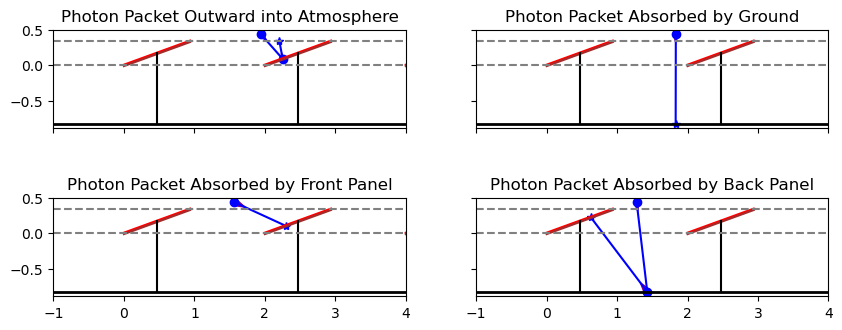

In [21]:
fig, axs = plt.subplots(2, 2, figsize=(10, 4), sharex=True, sharey=True)
axs.flat[0].set_title('Photon Packet Outward into Atmosphere')
axs.flat[1].set_title('Photon Packet Absorbed by Ground')
axs.flat[2].set_title('Photon Packet Absorbed by Front Panel')
axs.flat[3].set_title('Photon Packet Absorbed by Back Panel')
for ax in axs.flat:
  ax.set_xlim(-1.0, 4.0)

def calc(frac, panel_height, panel_tilt_deg,
         albf, albb, albg, init_angle, mu0, phi0):
  scene_length = 1.0 / frac
  panel_tilt_rad = math.radians(panel_tilt_deg)
  return doDownwardRadiation2D(
    1, 1.0, panel_height, scene_length, panel_tilt_rad, albf, albb, albg,
    mu0 if init_angle else None, math.radians(phi0), True
  )

for i, ax, target in zip(
  range(4), axs.flat,
  ('n_upward', 'n_ground', 'n_front', 'n_back')
):
  while True:
    result = calc(**inputs)
    if result[target] <= 0:
      continue
    hist = result['hist'][0]
    xs = [p[0] for p in hist]
    ys = [p[1] for p in hist]
    if max(xs) > 4.0 or min(xs) < -1.0:
      continue
    plotSingleRayTracing2D(
      hist, 1.0, inputs['panel_height'], 1.0/inputs['frac'], 
      math.radians(inputs['panel_tilt_deg']), ax
    )
    break

## Figure 2

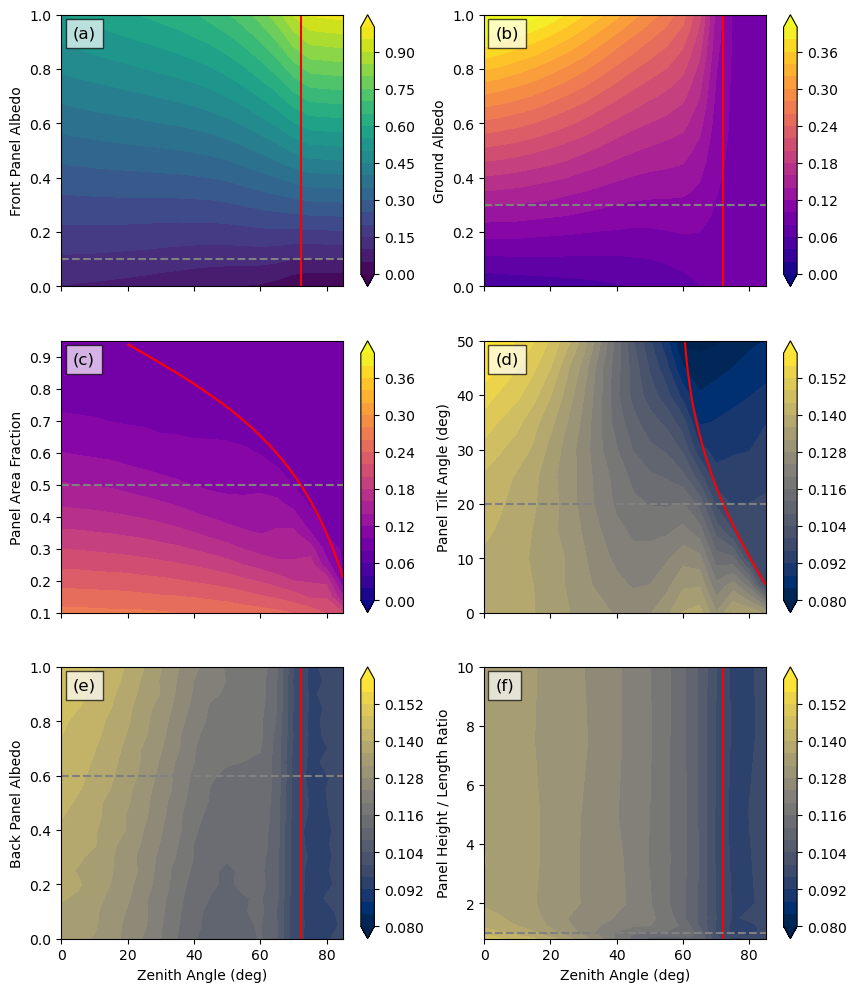

In [22]:
fig, axs = plt.subplots(3, 2, figsize=(10, 12), sharex=True)
kwargs = (
  {"levels": np.linspace(0.0, 1.0, 21),   "cmap": "viridis"},
  {"levels": np.linspace(0.0, 0.4, 21),   "cmap": "plasma"},
  {"levels": np.linspace(0.0, 0.4, 21),   "cmap": "plasma"},
  {"levels": np.linspace(0.08, 0.16, 21), "cmap": "cividis"},
  {"levels": np.linspace(0.08, 0.16, 21), "cmap": "cividis"},
  {"levels": np.linspace(0.08, 0.16, 21), "cmap": "cividis"},
)
for ax, tbl, ylabel, kw in zip(
  axs.flatten(),
  ('refl_dir_albf', 'refl_dir_albg', 'refl_dir_panel_frac',
   'refl_dir_panel_angle', 'refl_dir_albb', 'refl_dir_panel_hgt'),
  ('Front Panel Albedo', 'Ground Albedo', 'Panel Area Fraction',
   'Panel Tilt Angle (deg)', 'Back Panel Albedo', 'Panel Height / Length Ratio'),
   kwargs
):
  v = ds[tbl]
  x = v.coords['zenith_angle']
  y = v.coords[v.dims[0]]
  p = ax.contourf(x, y, v, extend='both', **kw)
  plt.colorbar(p, ax=ax)
  ax.set_ylabel(ylabel)

x = np.arange(0.0, 85.0, 0.1)
y = np.arange(0.10, 0.95, 0.02)
xx, yy = np.meshgrid(x, y)
z = np.cos(defaults['panel_tilt_rad']) + np.sin(defaults['panel_tilt_rad']) * np.tan(np.deg2rad(xx))
z = z * yy
axs.flat[2].contour(x, y, z, levels=[0.0, 1.0, 99.0], colors='r')

x = np.arange(0.0, 85.0, 0.1)
y = np.arange(0.0, 50.0, 0.1)
xx, yy = np.meshgrid(x, y)
z = np.cos(np.deg2rad(yy)) + np.sin(np.deg2rad(yy)) * np.tan(np.deg2rad(xx))
axs.flat[3].contour(x, y, z, levels=[0.0, 2.0, 99.0], colors='r')

angle = np.rad2deg(
    np.arctan(
        (2-np.cos(defaults['panel_tilt_rad'])) / np.sin(defaults['panel_tilt_rad'])
    )
)
for ax in (axs.flat[[0,1,4,5]]):
  ax.axvline(x=angle, c='r')

axs.flat[0].axhline(y=defaults['albedo_front_panel'], c='gray', ls='--')
axs.flat[1].axhline(y=defaults['albedo_ground'], c='gray', ls='--')
axs.flat[2].axhline(y=defaults['panel_length'] / defaults['scene_length'], c='gray', ls='--')
axs.flat[3].axhline(y=np.rad2deg(defaults['panel_tilt_rad']), c='gray', ls='--')
axs.flat[4].axhline(y=defaults['albedo_back_panel'], c='gray', ls='--')
axs.flat[5].axhline(y=defaults['panel_height'] / defaults['panel_length'], c='gray', ls='--')

for ax in axs[-1,:]:
  ax.set_xlabel('Zenith Angle (deg)')
for i, ax in enumerate(axs.flat):
  ax.text(0.04, 0.96, '({})'.format(chr(97+i)), transform=ax.transAxes, va='top',
          fontsize=12, bbox=dict(facecolor='w', edgecolor='k', pad=5, alpha=0.7))

## Figure 4 (Summer)

97/97 [#############################################] 100.0%
Reflected
MEAN 0.14342437037037037
MAX 0.169997
MIN 0.111022
Absorbed by Ground
MEAN 0.4620632037037037
MAX 0.754534
MIN 0.398457
Absorbed by Front Panel
MEAN 0.3382041481481482
MAX 0.430057
MIN 0.006452
Absorbed by Back Panel
MEAN 0.05630827777777778
MAX 0.435546
MIN 0.029852


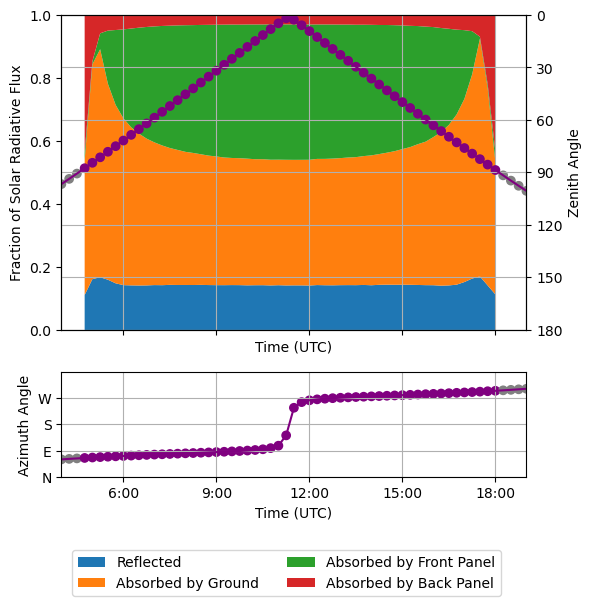

In [23]:
args = {'frac': 0.5, 'panel_height': 1.0, 'panel_tilt_deg': 20.0,
        'albf': 0.1, 'albb': 0.6, 'albg': 0.3,
        'lat': 25.0, 'lon': 10.0, 'declin': 23.5}
fig, axs = g2(**args)

## Figure 4 (Winter)

97/97 [#############################################] 100.0%
Reflected
MEAN 0.11106678571428572
MAX 0.116254
MIN 0.094939
Absorbed by Ground
MEAN 0.1784439761904762
MAX 0.261138
MIN 0.001867
Absorbed by Front Panel
MEAN 0.6941752380952382
MAX 0.900357
MIN 0.599235
Absorbed by Back Panel
MEAN 0.016314000000000002
MAX 0.024501
MIN 0.000892


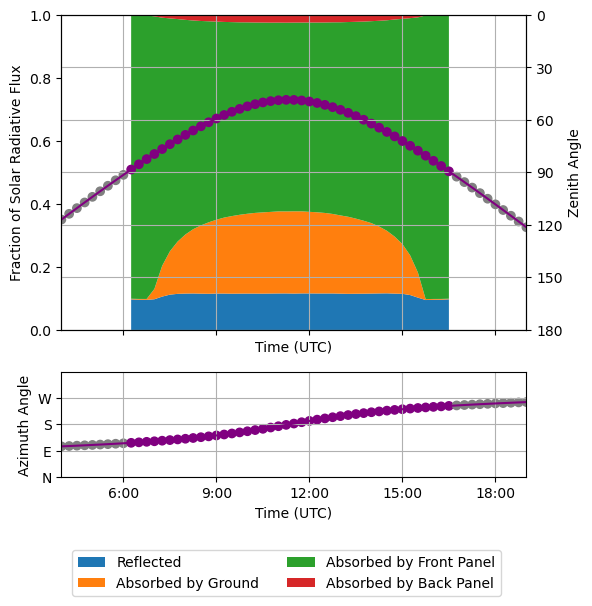

In [24]:
args = {'frac': 0.5, 'panel_height': 1.0, 'panel_tilt_deg': 20.0,
        'albf': 0.1, 'albb': 0.6, 'albg': 0.3,
        'lat': 25.0, 'lon': 10.0, 'declin': -23.5}
fig, axs = g2(**args)

## Figure 7 (Summer)

To run the following blocks, lookup tables should be generated by running `SolarFarmSpecTableMPI.py`.

In [25]:
lat = 25.0; lon = 10.0; declin = 23.5

In [26]:
zenith, azimuth = [], []
jdays = np.linspace(0.0, 1.0, 24 * 6 + 1)
for jday in jdays:
  sa = SolarAngles(math.radians(lat), math.radians(lon), math.radians(declin), jday)
  zenith.append(sa[0])
  azimuth.append(sa[1])

temp = np.full(len(zenith), np.nan, dtype=object)
refl = np.full(len(zenith), np.nan)
absg = np.full(len(zenith), np.nan)
absf = np.full(len(zenith), np.nan)
absb = np.full(len(zenith), np.nan)

with Pool() as pool:
  for i in range(len(zenith)):
    args = defaults.copy()
    args['mu0'] = -math.cos(math.radians(zenith[i]))
    args['phi0'] = math.radians(azimuth[i]-180.0)
    temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  count = 0
  while count < len(zenith):
    count = sum([temp[i]==np.nan or temp[i].ready() for i in range(len(zenith))])
    printProgressBar(count, len(zenith))
    sleep(1)
  print('')

for i in range(len(zenith)):
  if zenith[i] > 90.0:
    continue
  refl[i] = temp[i].get()['n_upward'] / args['nphotons']
  absg[i] = temp[i].get()['n_ground'] / args['nphotons']
  absf[i] = temp[i].get()['n_front'] / args['nphotons']
  absb[i] = temp[i].get()['n_back'] / args['nphotons']

145/145 [###########################################] 100.0%


In [27]:
zenith2, azimuth2 = [], []
jdays2 = np.linspace(0.0, 1.0, 24 * 6 + 1)
for jday in jdays2:
  sa = SolarAngles(math.radians(lat), math.radians(lon), math.radians(declin), jday)
  zenith2.append(sa[0])
  azimuth2.append(sa[1])

frac_refl = xa.open_dataset(SOLAR_FARM_SPEC)['frac_swdir_refl']
frac_absg = xa.open_dataset(SOLAR_FARM_SPEC)['frac_swdir_grnd']
frac_absf = xa.open_dataset(SOLAR_FARM_SPEC)['frac_swdir_upnl']
frac_absb = xa.open_dataset(SOLAR_FARM_SPEC)['frac_swdir_dpnl']

refl2 = np.full(len(zenith2), np.nan)
absg2 = np.full(len(zenith2), np.nan)
absf2 = np.full(len(zenith2), np.nan)
absb2 = np.full(len(zenith2), np.nan)

for i in range(len(zenith2)):
  if zenith2[i] > 90.0:
    continue
#   refl2[i] = frac_refl.sel(solar_zenith_angle=zenith2[i],
#       solar_azimuth_angle=azimuth2[i],
#       surface_albedo=defaults['albedo_ground'], method='nearest')
#   absg2[i] = frac_absg.sel(solar_zenith_angle=zenith2[i],
#       solar_azimuth_angle=azimuth2[i],
#       surface_albedo=defaults['albedo_ground'], method='nearest')
#   absf2[i] = frac_absf.sel(solar_zenith_angle=zenith2[i],
#       solar_azimuth_angle=azimuth2[i],
#       surface_albedo=defaults['albedo_ground'], method='nearest')
#   absb2[i] = frac_absb.sel(solar_zenith_angle=zenith2[i],
#       solar_azimuth_angle=azimuth2[i],
#       surface_albedo=defaults['albedo_ground'], method='nearest')
  refl2[i] = frac_refl.interp(solar_zenith_angle=zenith2[i],
        solar_azimuth_angle=azimuth2[i],
        surface_albedo=defaults['albedo_ground'], method='linear',
        kwargs={"fill_value": "extrapolate"})
  absg2[i] = frac_absg.interp(solar_zenith_angle=zenith2[i],
        solar_azimuth_angle=azimuth2[i],
        surface_albedo=defaults['albedo_ground'], method='linear',
        kwargs={"fill_value": "extrapolate"})
  absf2[i] = frac_absf.interp(solar_zenith_angle=zenith2[i],
        solar_azimuth_angle=azimuth2[i],
        surface_albedo=defaults['albedo_ground'], method='linear',
        kwargs={"fill_value": "extrapolate"})
  absb2[i] = frac_absb.interp(solar_zenith_angle=zenith2[i],
        solar_azimuth_angle=azimuth2[i],
        surface_albedo=defaults['albedo_ground'], method='linear',
        kwargs={"fill_value": "extrapolate"})

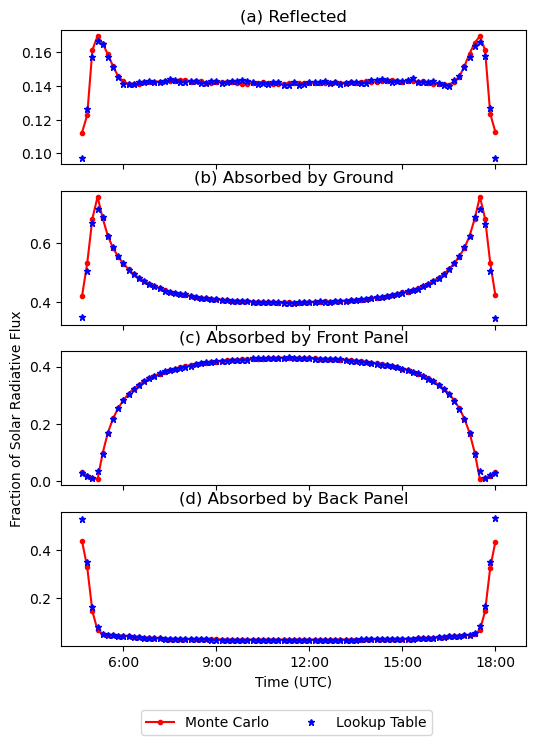

In [28]:
fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True)

for ax, v, label in zip(axs.flat,
  (refl, absg, absf, absb),
  ('(a) Reflected', '(b) Absorbed by Ground',
   '(c) Absorbed by Front Panel', '(d) Absorbed by Back Panel')
):
  ax.plot(jdays, v, 'r.-', label='Monte Carlo')
  ax.set_title(label)
  ax.grid()

for ax, v in zip(axs.flat,
  (refl2, absg2, absf2, absb2)
):
  ax.step(jdays2, v, 'b*', where='post', markersize=5, label='Lookup Table')
  ax.grid()

axs[-1].set_xlim(4./24, 19./24)
axs[-1].set_xticks(
  np.arange(6/24, 18.1/24, 3/24),
  ['6:00', '9:00', '12:00', '15:00', '18:00']
)
axs[-1].set_xlabel('Time (UTC)')
axs[-2].set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.01, 1.0, 0.05))

(a) Reflected
MEAN -3.7381e-04
MAX 3.7398e-03
MIN -1.5294e-02
(b) Absorbed by Ground
MEAN -3.5404e-03
MAX 5.5403e-03
MIN -7.7607e-02
(c) Absorbed by Front Panel
MEAN 1.1873e-04
MAX 2.8658e-02
MIN -5.2786e-03
(d) Absorbed by Back Panel
MEAN 3.7955e-03
MAX 9.6737e-02
MIN -1.1953e-03


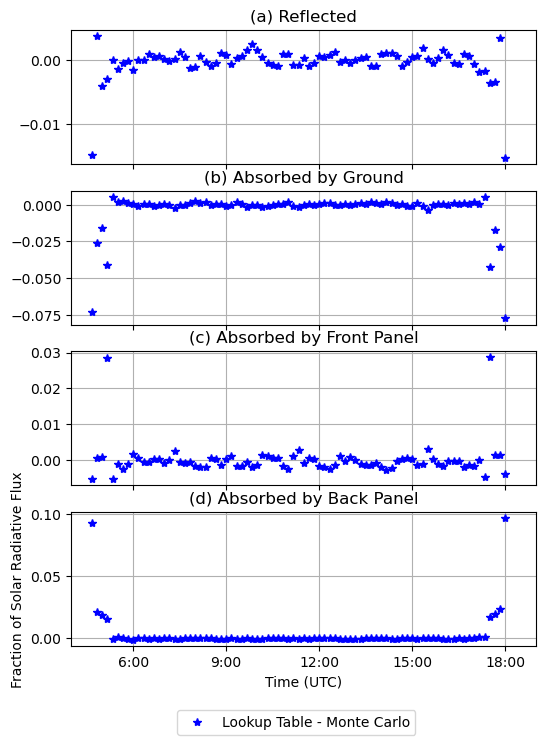

In [29]:
fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True)

for ax, v, label in zip(axs.flat,
  (refl2-refl, absg2-absg, absf2-absf, absb2-absb),
  ('(a) Reflected', '(b) Absorbed by Ground',
   '(c) Absorbed by Front Panel', '(d) Absorbed by Back Panel')
):
  ax.plot(jdays, v, 'b*', label='Lookup Table - Monte Carlo')
  ax.set_title(label)
  ax.grid()
  print(label)
  print(f'MEAN {np.nanmean(v):.4e}')
  print(f'MAX {np.nanmax(v):.4e}')
  print(f'MIN {np.nanmin(v):.4e}')

axs[-1].set_xlim(4./24, 19./24)
axs[-1].set_xticks(
  np.arange(6/24, 18.1/24, 3/24),
  ['6:00', '9:00', '12:00', '15:00', '18:00']
)
axs[-1].set_xlabel('Time (UTC)')
axs[-1].set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.01, 1.0, 0.05))

## Figure 7 (Winter)

To run the following blocks, lookup tables should be generated by running `SolarFarmSpecTableMPI.py`.

In [30]:
lat = 25.0; lon = 10.0; declin = -23.5

In [31]:
zenith, azimuth = [], []
jdays = np.linspace(0.0, 1.0, 24 * 6 + 1)
for jday in jdays:
  sa = SolarAngles(math.radians(lat), math.radians(lon), math.radians(declin), jday)
  zenith.append(sa[0])
  azimuth.append(sa[1])

temp = np.full(len(zenith), np.nan, dtype=object)
refl = np.full(len(zenith), np.nan)
absg = np.full(len(zenith), np.nan)
absf = np.full(len(zenith), np.nan)
absb = np.full(len(zenith), np.nan)

with Pool() as pool:
  for i in range(len(zenith)):
    args = defaults.copy()
    args['mu0'] = -math.cos(math.radians(zenith[i]))
    args['phi0'] = math.radians(azimuth[i]-180.0)
    temp[i] = pool.apply_async(doDownwardRadiation2D, kwds=args)
  pool.close()
  count = 0
  while count < len(zenith):
    count = sum([temp[i]==np.nan or temp[i].ready() for i in range(len(zenith))])
    printProgressBar(count, len(zenith))
    sleep(1)
  print('')

for i in range(len(zenith)):
  if zenith[i] > 90.0:
    continue
  refl[i] = temp[i].get()['n_upward'] / args['nphotons']
  absg[i] = temp[i].get()['n_ground'] / args['nphotons']
  absf[i] = temp[i].get()['n_front'] / args['nphotons']
  absb[i] = temp[i].get()['n_back'] / args['nphotons']

145/145 [###########################################] 100.0%


In [32]:
zenith2, azimuth2 = [], []
jdays2 = np.linspace(0.0, 24.0, 24 * 6 + 1) / 24.0
for jday in jdays2:
  sa = SolarAngles(math.radians(lat), math.radians(lon), math.radians(declin), jday)
  zenith2.append(sa[0])
  azimuth2.append(sa[1])

frac_refl = xa.open_dataset(SOLAR_FARM_SPEC)['frac_swdir_refl']
frac_absg = xa.open_dataset(SOLAR_FARM_SPEC)['frac_swdir_grnd']
frac_absf = xa.open_dataset(SOLAR_FARM_SPEC)['frac_swdir_upnl']
frac_absb = xa.open_dataset(SOLAR_FARM_SPEC)['frac_swdir_dpnl']

refl2 = np.full(len(zenith2), np.nan)
absg2 = np.full(len(zenith2), np.nan)
absf2 = np.full(len(zenith2), np.nan)
absb2 = np.full(len(zenith2), np.nan)

for i in range(len(zenith2)):
  if zenith2[i] > 90.0:
    continue
#   refl2[i] = frac_refl.sel(solar_zenith_angle=zenith2[i],
#       solar_azimuth_angle=azimuth2[i],
#       surface_albedo=defaults['albedo_ground'], method='nearest')
#   absg2[i] = frac_absg.sel(solar_zenith_angle=zenith2[i],
#       solar_azimuth_angle=azimuth2[i],
#       surface_albedo=defaults['albedo_ground'], method='nearest')
#   absf2[i] = frac_absf.sel(solar_zenith_angle=zenith2[i],
#       solar_azimuth_angle=azimuth2[i],
#       surface_albedo=defaults['albedo_ground'], method='nearest')
#   absb2[i] = frac_absb.sel(solar_zenith_angle=zenith2[i],
#       solar_azimuth_angle=azimuth2[i],
#       surface_albedo=defaults['albedo_ground'], method='nearest')
  refl2[i] = frac_refl.interp(solar_zenith_angle=zenith2[i],
        solar_azimuth_angle=azimuth2[i],
        surface_albedo=defaults['albedo_ground'], method='linear',
        kwargs={"fill_value": "extrapolate"})
  absg2[i] = frac_absg.interp(solar_zenith_angle=zenith2[i],
        solar_azimuth_angle=azimuth2[i],
        surface_albedo=defaults['albedo_ground'], method='linear',
        kwargs={"fill_value": "extrapolate"})
  absf2[i] = frac_absf.interp(solar_zenith_angle=zenith2[i],
        solar_azimuth_angle=azimuth2[i],
        surface_albedo=defaults['albedo_ground'], method='linear',
        kwargs={"fill_value": "extrapolate"})
  absb2[i] = frac_absb.interp(solar_zenith_angle=zenith2[i],
        solar_azimuth_angle=azimuth2[i],
        surface_albedo=defaults['albedo_ground'], method='linear',
        kwargs={"fill_value": "extrapolate"})

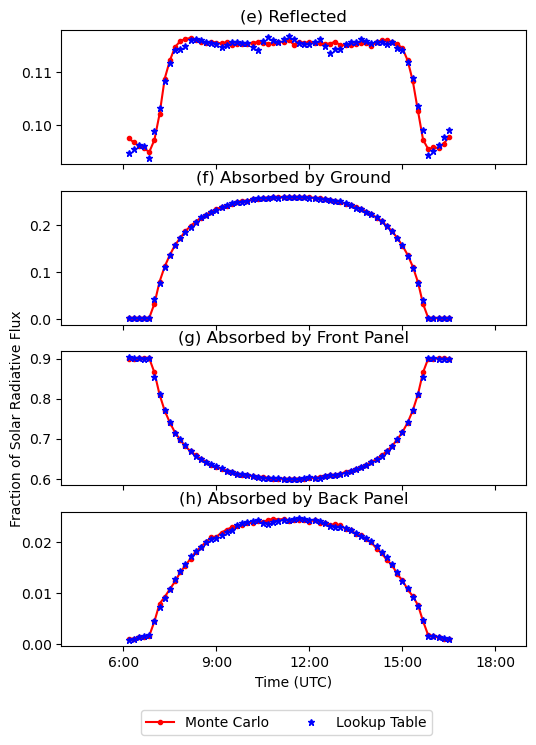

In [33]:
fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True)

for ax, v, label in zip(axs.flat,
  (refl, absg, absf, absb),
  ('(e) Reflected', '(f) Absorbed by Ground',
   '(g) Absorbed by Front Panel', '(h) Absorbed by Back Panel')
):
  ax.plot(jdays, v, 'r.-', label='Monte Carlo')
  ax.set_title(label)
  ax.grid()

for ax, v in zip(axs.flat,
  (refl2, absg2, absf2, absb2)
):
  ax.step(jdays2, v, 'b*', where='post', markersize=5, label='Lookup Table')
  ax.grid()

axs[-1].set_xlim(4./24, 19./24)
axs[-1].set_xticks(
  np.arange(6/24, 18.1/24, 3/24),
  ['6:00', '9:00', '12:00', '15:00', '18:00']
)
axs[-1].set_xlabel('Time (UTC)')
axs[-2].set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.01, 1.0, 0.05))

(e) Reflected
MEAN -6.6117e-05
MAX 1.7676e-03
MIN -2.5139e-03
(f) Absorbed by Ground
MEAN -1.2137e-04
MAX 9.8587e-03
MIN -2.9064e-03
(g) Absorbed by Front Panel
MEAN 1.8487e-04
MAX 2.9839e-03
MIN -1.1220e-02
(h) Absorbed by Back Panel
MEAN 2.6207e-06
MAX 5.4914e-04
MIN -8.3070e-04


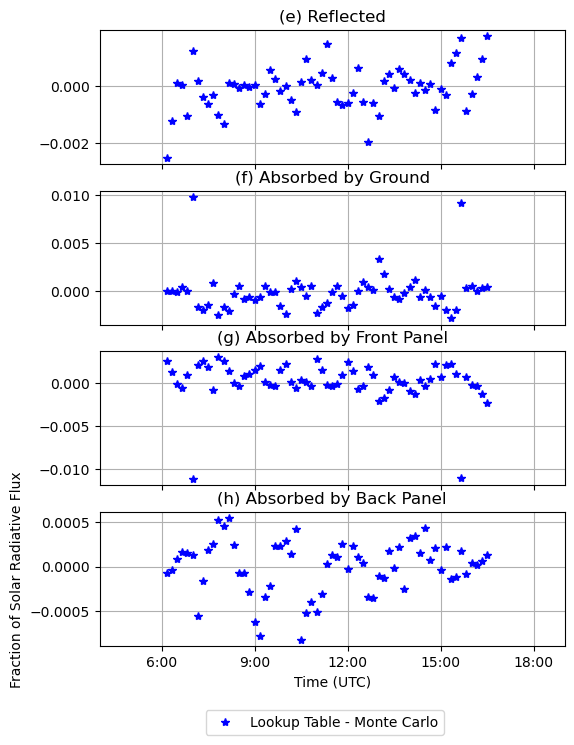

In [ ]:
fig, axs = plt.subplots(4, 1, figsize=(6, 8), sharex=True)

for ax, v, label in zip(axs.flat,
  (refl2-refl, absg2-absg, absf2-absf, absb2-absb),
  ('(e) Reflected', '(f) Absorbed by Ground',
   '(g) Absorbed by Front Panel', '(h) Absorbed by Back Panel')
):
  ax.plot(jdays, v, 'b*', label='Lookup Table - Monte Carlo')
  ax.set_title(label)
  ax.grid()
  print(label)
  print(f'MEAN {np.nanmean(v):.4e}')
  print(f'MAX {np.nanmax(v):.4e}')
  print(f'MIN {np.nanmin(v):.4e}')

axs[-1].set_xlim(4./24, 19./24)
axs[-1].set_xticks(
  np.arange(6/24, 18.1/24, 3/24),
  ['6:00', '9:00', '12:00', '15:00', '18:00']
)
axs[-1].set_xlabel('Time (UTC)')
axs[-1].set_ylabel('Fraction of Solar Radiative Flux')

handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.0, -0.01, 1.0, 0.05))